### Table of contents
1. [Figure 3B. Scatter plots showing IFN inducibility of cell type-specific genes and ISGs in TAM, Tumor, and CD8s](#1)
2. [Score cells for cell type-specific ISG signatures for visualization purposes](#2)
3. [Define IFNG and IFN1 response high and low cells using CytoSig p-values for visualization purposes](#3)
4. [Heatmap of type I and type II cell type-specific ISGs](#4)
5. [Figure 3C and 3D. Violin plots of ISG signature scores in IFN1 and IFNG response high and low cells in samples from treated patients](#5)
6. [Score IMM151 and JAV101 bulk RNA-Seq for ISG signatures and add CIBERSORTx fractions](#6)
7. [Figure 3E and 3F. Violin plots of ISG signature scores in IMM151 and JAV101 in samples grouped by IFNG expression and cell type fractions](#7)

In [1]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(ggrastr)
library(magrittr)
library(broom)
library(yarrr)

set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

Loading required package: Rcpp

Loading required package: carData

corrplot 0.92 loaded

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject

Attaching sp

Loading required package: ggplot2


Attaching package: 'dplyr'


The following object is masked from 'package:car

### Figure 3B. Scatter plots showing IFN inducibility of cell type-specific genes and ISGs in TAM, Tumor, and CD8s <a name="1"></a>

### First, we retrieve type I and type II inducibility inferrence outputs from the mixed effects models

In [11]:
seur_full_notx_allstages = readRDS("../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

goi = readRDS("../Signatures/manuscript_goi_hallmark_benciminn_curated.RDS")
length(goi)
length(unique(goi))

celltypes = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes

type1_isg = list()
type2_isg = list()

for (i in 1:length(celltypes)) {
    lmres = readRDS(paste("../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/",celltypes[i],"_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS", sep = ""))
    lmres_sub = subset(lmres, gene %in% goi)
    
    type1_isg[[i]] = subset(lmres_sub, IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH < 0.01)$gene
    type2_isg[[i]] = subset(lmres_sub, IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH < 0.01)$gene
}

names(type1_isg) = celltypes
names(type2_isg) = celltypes

[1] 259

[1] 259

[1] "Tumor"                       "Monocyte"                   
 [3] "TAM"                         "CD8"                        
 [5] "Plasma cell"                 "CD8 NK-like"                
 [7] "DC"                          "Endothelial"                
 [9] "T-reg"                       "NK"                         
[11] "T-Helper"                    "B cell"                     
[13] "Perivascular_and_Fibroblast"

### Identify cell type-specific genes and ISGs as shown previously

### TAM

In [12]:
myeloid_dropped_comparisons = c("TAM","Monocyte","DC")

drop = myeloid_dropped_comparisons

#Get vector of cell types to consider in one vs each DE

celltypes_TAM = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_TAM = subset(celltypes_TAM, !(celltypes_TAM %in% drop))
celltypes_TAM

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in TAM
TAM_cts = list()

for (i in 1:length(celltypes_TAM)){
    cts_de = readRDS(paste("../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/TAM/TAM_vs_",celltypes_TAM[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    TAM_cts[[i]] = row.names(cts_de)    
}

names(TAM_cts) = celltypes_TAM

#Get final unified vector of cell type-specific genes
Reduced_TAM_cts = Reduce(intersect, TAM_cts)
#Reduced_TAM_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
TAM_IFN1 = intersect(Reduce(intersect, TAM_cts), type1_isg$TAM)
TAM_IFN1

TAM_IFNG = intersect(Reduce(intersect, TAM_cts), type2_isg$TAM)
TAM_IFNG

[1] "Tumor"                       "CD8"                        
 [3] "Plasma cell"                 "CD8 NK-like"                
 [5] "Endothelial"                 "T-reg"                      
 [7] "NK"                          "T-Helper"                   
 [9] "B cell"                      "Perivascular_and_Fibroblast"

[1] "IFI30"  "LPAR6"  "FCGR1A" "MYD88"  "VSIG4"  "LILRB1" "IL10"   "SECTM1"
 [9] "MX2"    "CXCL10"

[1] "CD86"     "FCGR1A"   "FPR1"     "MYD88"    "SIGLEC10" "LILRB1"  
 [7] "SECTM1"   "JAK2"     "CXCL10"   "CXCL9"    "TNFAIP2"  "PTGS2"   
[13] "IL15"

### Tumor and fibroblast

In [13]:
tumor_dropped_comparisons = c("Tumor","Perivascular_and_Fibroblast")

drop = tumor_dropped_comparisons

#Get vector of cell types to consider in one vs each DE

celltypes_Tumor = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_Tumor = subset(celltypes_Tumor, !(celltypes_Tumor %in% drop))
celltypes_Tumor

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in Tumor
Tumor_cts = list()

for (i in 1:length(celltypes_Tumor)){
    cts_de = readRDS(paste("../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/Tumor/Tumor_vs_",celltypes_Tumor[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    Tumor_cts[[i]] = row.names(cts_de)    
}

names(Tumor_cts) = celltypes_Tumor

#Get final unified vector of cell type-specific genes
Reduced_Tumor_cts = Reduce(intersect, Tumor_cts)
#Reduced_Tumor_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
Tumor_IFN1 = intersect(Reduce(intersect, Tumor_cts), type1_isg$Tumor)
Tumor_IFN1

Tumor_IFNG = intersect(Reduce(intersect, Tumor_cts), type2_isg$Tumor)
Tumor_IFNG

[1] "Monocyte"    "TAM"         "CD8"         "Plasma cell" "CD8 NK-like"
 [6] "DC"          "Endothelial" "T-reg"       "NK"          "T-Helper"   
[11] "B cell"

[1] "C1R"     "PFKP"    "TNFAIP6"

[1] "C1S"  "C1R"  "CFB"  "SSPN"

### CD8

In [14]:
t_nk_dropped_comparisons = c("CD8 NK-like","NK","T-Helper","T-reg","CD8")

drop = t_nk_dropped_comparisons

#Get vector of cell types to consider in one vs each DE

celltypes_CD8 = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_CD8 = subset(celltypes_CD8, !(celltypes_CD8 %in% drop))
celltypes_CD8

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in CD8
CD8_cts = list()

for (i in 1:length(celltypes_CD8)){
    cts_de = readRDS(paste("../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/CD8/CD8_vs_",celltypes_CD8[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    CD8_cts[[i]] = row.names(cts_de)    
}

names(CD8_cts) = celltypes_CD8

#Get final unified vector of cell type-specific genes
Reduced_CD8_cts = Reduce(intersect, CD8_cts)
#Reduced_CD8_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
CD8_IFN1 = intersect(Reduce(intersect, CD8_cts), type1_isg$CD8)
CD8_IFN1

CD8_IFNG = intersect(Reduce(intersect, CD8_cts), type2_isg$CD8)
CD8_IFNG

[1] "Tumor"                       "Monocyte"                   
[3] "TAM"                         "Plasma cell"                
[5] "DC"                          "Endothelial"                
[7] "B cell"                      "Perivascular_and_Fibroblast"

[1] "NLRC5" "OASL"

[1] "CCL5"  "GZMA"  "IL2RB" "NLRC5" "OASL"

### T-Helper

In [15]:
t_nk_dropped_comparisons = c("CD8 NK-like","NK","T-Helper","T-reg","CD8")

#Get vector of cell types to consider in one vs each DE

celltypes_T_Helper = unique(as.character(Idents(seur_full_notx_allstages)))
celltypes_T_Helper = subset(celltypes_T_Helper, !(celltypes_T_Helper %in% drop))
celltypes_T_Helper

#For each comparitor cell type, retrieve DE results and store genes signficantly enriched in T_Helper
T_Helper_cts = list()

for (i in 1:length(celltypes_T_Helper)){
    cts_de = readRDS(paste("../Outputs/Manuscript_CellTypeSpecific_DE_Output_Stage_Corrected_EarlyLate/T-Helper/T-Helper_vs_",celltypes_T_Helper[i],"_CellTypeSpecific_DE_Manuscript_Vargenes2000_LR_Patient_Stage_Corrected_EarlyLate.RDS",sep = ""))
    cts_de$diff = cts_de$pct.1 - cts_de$pct.2

    cts_de = subset(cts_de, p_val_adj < 0.05 & avg_log2FC > 0 & diff > 0 & pct.2 < 0.2)
    T_Helper_cts[[i]] = row.names(cts_de)    
}

names(T_Helper_cts) = celltypes_T_Helper

#Get final unified vector of cell type-specific genes
Reduced_T_Helper_cts = Reduce(intersect, T_Helper_cts)
#Reduced_T_Helper_cts

#Intersect these cell type-specific genes with type I and type II IFN inducible genes
T_Helper_IFN1 = intersect(Reduce(intersect, T_Helper_cts), type1_isg$`T-Helper`)
T_Helper_IFN1

T_Helper_IFNG = intersect(Reduce(intersect, T_Helper_cts), type2_isg$`T-Helper`)
T_Helper_IFNG

[1] "Tumor"                       "Monocyte"                   
[3] "TAM"                         "Plasma cell"                
[5] "DC"                          "Endothelial"                
[7] "B cell"                      "Perivascular_and_Fibroblast"

[1] "CCL5"  "GZMA"  "STAT4" "IL2RB" "XCL1"  "NLRC5"

[1] "CCL5"  "GZMA"  "SOCS1" "NLRC5"

### Retrieve various stats for plotting

In [16]:
seur_TAM = subset(seur_full_notx_allstages, idents = "TAM")
seur_Tumor = subset(seur_full_notx_allstages, idents = "Tumor")
seur_CD8 = subset(seur_full_notx_allstages, idents = "CD8")
seur_T_Helper = subset(seur_full_notx_allstages, idents = "T-Helper")

In [17]:
TAM_tot = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "BBK_Broad_Celltype_DE")$data
TAM_tot = TAM_tot[,c("pct.exp","features.plot")]
colnames(TAM_tot) = c("Total_Pct_Expressing","gene")
head(TAM_tot)

##

TAM_Sample = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "Sample")$data

TAM_Sample_collapsed = TAM_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(TAM_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(TAM_Sample_collapsed)
dim(TAM_Sample_collapsed)

##

TAM_Patient = DotPlot(seur_TAM, features = Reduced_TAM_cts, group.by = "Patient")$data

TAM_Patient_collapsed = TAM_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(TAM_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(TAM_Patient_collapsed)
dim(TAM_Patient_collapsed)

##

TAM_stats = left_join(TAM_tot, TAM_Sample_collapsed, by = "gene")
TAM_stats = left_join(TAM_stats, TAM_Patient_collapsed, by = "gene")
head(TAM_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


,Total_Pct_Expressing,gene
,<dbl>,<fct>
CCRL2,21.88958,CCRL2
IFI30,60.32020,IFI30
LPAR6,58.50384,LPAR6
CD86,66.41539,CD86
FCGR1A,68.04509,FCGR1A
FPR1,59.63099,FPR1


gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median
<fct>,<dbl>,<dbl>
CCRL2,25.00000,0.2478615
IFI30,68.72964,2.0574638
LPAR6,58.13953,1.2665822
CD86,70.97187,1.5771662
FCGR1A,67.79232,1.9301279
FPR1,62.98077,1.5199804


[1] 339   3

gene,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
<fct>,<dbl>,<dbl>
CCRL2,25.44757,0.2299451
IFI30,68.72964,1.8550056
LPAR6,59.62653,1.2642940
CD86,71.21212,1.4786767
FCGR1A,67.79232,2.1383539
FPR1,63.56589,1.5199804


[1] 339   3

,Total_Pct_Expressing,gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,21.88958,CCRL2,25.00000,0.2478615,25.44757,0.2299451
2,60.32020,IFI30,68.72964,2.0574638,68.72964,1.8550056
3,58.50384,LPAR6,58.13953,1.2665822,59.62653,1.2642940
4,66.41539,CD86,70.97187,1.5771662,71.21212,1.4786767
5,68.04509,FCGR1A,67.79232,1.9301279,67.79232,2.1383539
6,59.63099,FPR1,62.98077,1.5199804,63.56589,1.5199804


In [18]:
Tumor_tot = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "BBK_Broad_Celltype_DE")$data
Tumor_tot = Tumor_tot[,c("pct.exp","features.plot")]
colnames(Tumor_tot) = c("Total_Pct_Expressing","gene")
head(Tumor_tot)

##

Tumor_Sample = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "Sample")$data

Tumor_Sample_collapsed = Tumor_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(Tumor_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(Tumor_Sample_collapsed)
dim(Tumor_Sample_collapsed)

##

Tumor_Patient = DotPlot(seur_Tumor, features = Reduced_Tumor_cts, group.by = "Patient")$data

Tumor_Patient_collapsed = Tumor_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(Tumor_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(Tumor_Patient_collapsed)
dim(Tumor_Patient_collapsed)

##

Tumor_stats = left_join(Tumor_tot, Tumor_Sample_collapsed, by = "gene")
Tumor_stats = left_join(Tumor_stats, Tumor_Patient_collapsed, by = "gene")
head(Tumor_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


,Total_Pct_Expressing,gene
,<dbl>,<fct>
C1S,68.40028,C1S
C1R,61.18721,C1R
CFB,37.41970,CFB
PFKP,63.57867,PFKP
SSPN,43.43317,SSPN
RBP4,11.36909,RBP4


gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median
<fct>,<dbl>,<dbl>
C1S,45.0000000,1.45425909
C1R,30.0000000,0.89170930
CFB,38.4146341,0.78137426
PFKP,73.0386052,3.18277547
SSPN,36.5853659,0.78373577
RBP4,0.2038043,0.01130613


[1] 590   3

gene,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
<fct>,<dbl>,<dbl>
C1S,43.292683,1.33562312
C1R,28.048780,0.89170930
CFB,34.207650,0.78137426
PFKP,70.000000,3.18277547
SSPN,34.952446,0.77438269
RBP4,1.836296,0.01606899


[1] 590   3

,Total_Pct_Expressing,gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,68.40028,C1S,45.0000000,1.45425909,43.292683,1.33562312
2,61.18721,C1R,30.0000000,0.89170930,28.048780,0.89170930
3,37.41970,CFB,38.4146341,0.78137426,34.207650,0.78137426
4,63.57867,PFKP,73.0386052,3.18277547,70.000000,3.18277547
5,43.43317,SSPN,36.5853659,0.78373577,34.952446,0.77438269
6,11.36909,RBP4,0.2038043,0.01130613,1.836296,0.01606899


In [19]:
CD8_tot = DotPlot(seur_CD8, features = Reduced_CD8_cts, group.by = "BBK_Broad_Celltype_DE")$data
CD8_tot = CD8_tot[,c("pct.exp","features.plot")]
colnames(CD8_tot) = c("Total_Pct_Expressing","gene")
head(CD8_tot)

##

CD8_Sample = DotPlot(seur_CD8, features = Reduced_CD8_cts, group.by = "Sample")$data

CD8_Sample_collapsed = CD8_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(CD8_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(CD8_Sample_collapsed)
dim(CD8_Sample_collapsed)

##

CD8_Patient = DotPlot(seur_CD8, features = Reduced_CD8_cts, group.by = "Patient")$data

CD8_Patient_collapsed = CD8_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(CD8_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(CD8_Patient_collapsed)
dim(CD8_Patient_collapsed)

##

CD8_stats = left_join(CD8_tot, CD8_Sample_collapsed, by = "gene")
CD8_stats = left_join(CD8_stats, CD8_Patient_collapsed, by = "gene")
head(CD8_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


,Total_Pct_Expressing,gene
,<dbl>,<fct>
CCL5,96.38554,CCL5
GZMA,90.75199,GZMA
IL2RB,33.10617,IL2RB
STAT4,13.83101,STAT4
XCL1,14.36020,XCL1
XCL2,13.09289,XCL2


gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median
<fct>,<dbl>,<dbl>
CCL5,96.31602,46.4758132
GZMA,88.93645,16.3981236
IL2RB,35.82685,1.4234536
STAT4,17.39642,0.7435062
XCL1,14.24679,1.1747991
XCL2,12.13409,1.2164089


[1] 222   3

gene,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
<fct>,<dbl>,<dbl>
CCL5,95.94592,45.6672009
GZMA,89.30830,16.4570767
IL2RB,34.60608,1.4397462
STAT4,16.09427,0.7338699
XCL1,13.67631,1.1011541
XCL2,12.56614,1.2151971


[1] 222   3

,Total_Pct_Expressing,gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,96.38554,CCL5,96.31602,46.4758132,95.94592,45.6672009
2,90.75199,GZMA,88.93645,16.3981236,89.30830,16.4570767
3,33.10617,IL2RB,35.82685,1.4234536,34.60608,1.4397462
4,13.83101,STAT4,17.39642,0.7435062,16.09427,0.7338699
5,14.36020,XCL1,14.24679,1.1747991,13.67631,1.1011541
6,13.09289,XCL2,12.13409,1.2164089,12.56614,1.2151971


In [20]:
T_Helper_tot = DotPlot(seur_T_Helper, features = Reduced_T_Helper_cts, group.by = "BBK_Broad_Celltype_DE")$data
T_Helper_tot = T_Helper_tot[,c("pct.exp","features.plot")]
colnames(T_Helper_tot) = c("Total_Pct_Expressing","gene")
head(T_Helper_tot)

##

T_Helper_Sample = DotPlot(seur_T_Helper, features = Reduced_T_Helper_cts, group.by = "Sample")$data

T_Helper_Sample_collapsed = T_Helper_Sample %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Sample_Median=median(pct.exp),Avg_Exp_Sample_Median=median(avg.exp))
          
colnames(T_Helper_Sample_collapsed) = c("gene","Pct_Exp_Sample_Median","Avg_Exp_Sample_Median")
head(T_Helper_Sample_collapsed)
dim(T_Helper_Sample_collapsed)

##

T_Helper_Patient = DotPlot(seur_T_Helper, features = Reduced_T_Helper_cts, group.by = "Patient")$data

T_Helper_Patient_collapsed = T_Helper_Patient %>%
group_by(features.plot)%>% 
summarise(Pct_Exp_Patient_Median=median(pct.exp),Avg_Exp_Patient_Median=median(avg.exp))
          
colnames(T_Helper_Patient_collapsed) = c("gene","Pct_Exp_Patient_Median","Avg_Exp_Patient_Median")
head(T_Helper_Patient_collapsed)
dim(T_Helper_Patient_collapsed)

##

T_Helper_stats = left_join(T_Helper_tot, T_Helper_Sample_collapsed, by = "gene")
T_Helper_stats = left_join(T_Helper_stats, T_Helper_Patient_collapsed, by = "gene")
head(T_Helper_stats)

Warning message:
"Only one identity present, the expression values will be not scaled"


,Total_Pct_Expressing,gene
,<dbl>,<fct>
CCL5,50.31370,CCL5
GZMA,46.88436,GZMA
STAT4,32.88892,STAT4
IL7R,85.66947,IL7R
GZMK,29.28846,GZMK
BATF,30.45772,BATF


gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median
<fct>,<dbl>,<dbl>
CCL5,55.84147,7.309510
GZMA,48.70103,5.079093
STAT4,33.65949,1.392419
IL7R,87.68939,18.400092
GZMK,28.27197,2.695511
BATF,27.43565,1.305763


[1] 170   3

gene,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
<fct>,<dbl>,<dbl>
CCL5,52.92521,7.309510
GZMA,44.17863,4.960196
STAT4,33.33333,1.206516
IL7R,87.10260,17.481836
GZMK,30.43246,3.184287
BATF,27.84199,1.205488


[1] 170   3

,Total_Pct_Expressing,gene,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,50.31370,CCL5,55.84147,7.309510,52.92521,7.309510
2,46.88436,GZMA,48.70103,5.079093,44.17863,4.960196
3,32.88892,STAT4,33.65949,1.392419,33.33333,1.206516
4,85.66947,IL7R,87.68939,18.400092,87.10260,17.481836
5,29.28846,GZMK,28.27197,2.695511,30.43246,3.184287
6,30.45772,BATF,27.43565,1.305763,27.84199,1.205488


,IFN1_resp_beta,IFNG_resp_beta,IFN1_resp_pval,IFNG_resp_pval,gene,IFN1_resp_p_adj_BH,IFNG_resp_p_adj_BH,IFN1_resp_p_adj_Bonf,IFNG_resp_p_adj_Bonf,Total_Pct_Expressing,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.03583396,-0.005576054,1.398227e-02,6.580746e-01,CCRL2,7.121853e-02,8.342600e-01,1.000000e+00,1.000000e+00,21.889583,25.00000,0.2478615,25.447570,0.2299451
2,0.11235551,0.475487051,1.731467e-17,0.000000e+00,CXCL10,5.805170e-16,0.000000e+00,1.584811e-13,0.000000e+00,9.727906,11.14488,2.4063405,9.658725,3.1467955
3,0.11845986,-0.069187127,2.786851e-18,2.120246e-09,IFI30,1.004254e-16,2.691625e-08,2.550805e-14,1.940661e-05,60.320195,68.72964,2.0574638,68.729642,1.8550056
4,-0.02653439,0.179805593,6.891236e-02,1.580603e-45,IL15,2.428783e-01,1.063769e-43,1.000000e+00,1.446726e-41,15.349271,16.49726,0.1932749,17.594655,0.1932749
5,0.11046493,0.015511750,8.381629e-14,2.191781e-01,LPAR6,2.283246e-12,4.673480e-01,7.671705e-10,1.000000e+00,58.503841,58.13953,1.2665822,59.626529,1.2642940
6,-0.01115993,0.099305073,4.482736e-01,3.692882e-15,CD86,7.375220e-01,7.146078e-14,1.000000e+00,3.380095e-11,66.415392,70.97187,1.5771662,71.212121,1.4786767



       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         172           76           76           15 

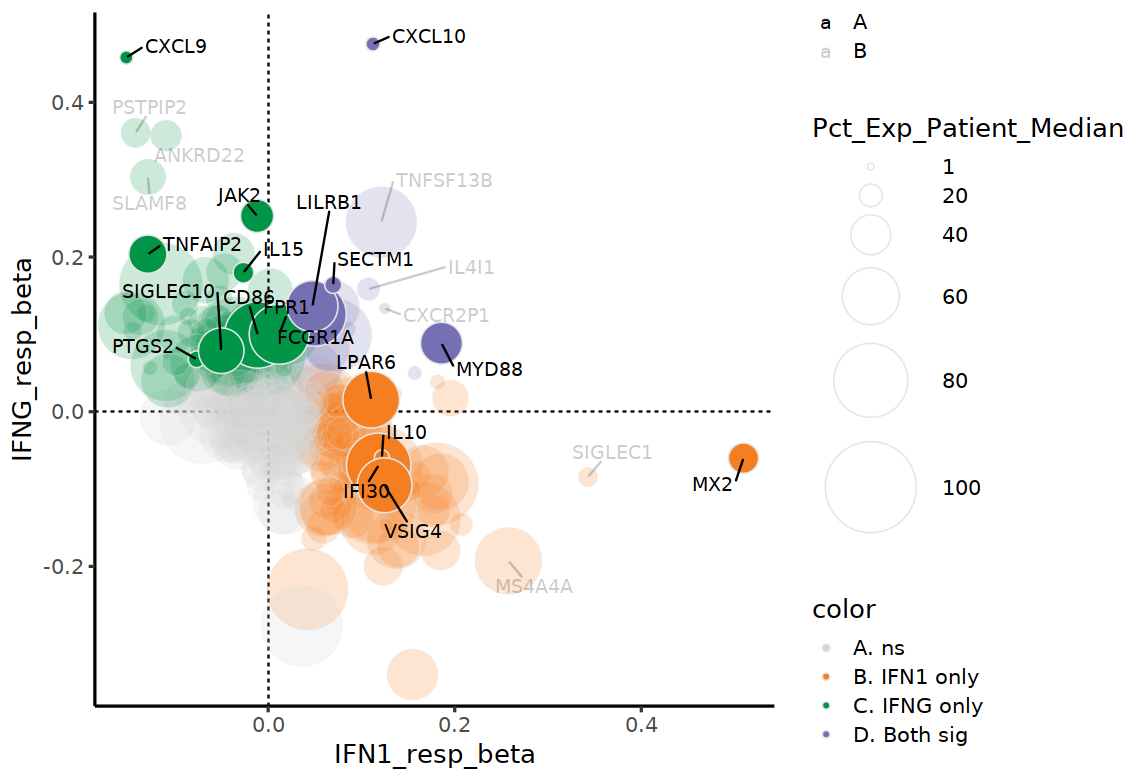

In [21]:
TAM = readRDS("../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/TAM_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
TAM = subset(TAM, gene %in% Reduced_TAM_cts)
TAM = left_join(TAM, TAM_stats, by = "gene")
head(TAM)

up_IFN1 = subset(TAM, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(TAM, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(TAM, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(TAM, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


TAM = mutate(TAM, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
TAM = mutate(TAM, label = ifelse(gene %in% c(TAM_IFN1, TAM_IFNG) | IFN1_resp_beta > 0.25 | IFNG_resp_beta > 0.25 | IFN1_resp_beta > 0.1 & IFNG_resp_beta > 0.1 ,gene,""))
TAM = mutate(TAM, alpha = ifelse(gene %in% c(TAM_IFN1, TAM_IFNG),"A","B"))
#head(TAM)
table(TAM$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(TAM %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) 
#ylim(c(-0.22,0.225)) +
#xlim(c(-0.075,0.17))
ggsave("../Figures/Figure3/Figure_3B_TAM_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

,IFN1_resp_beta,IFNG_resp_beta,IFN1_resp_pval,IFNG_resp_pval,gene,IFN1_resp_p_adj_BH,IFNG_resp_p_adj_BH,IFN1_resp_p_adj_Bonf,IFNG_resp_p_adj_Bonf,Total_Pct_Expressing,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.12175930,0.42061864,6.628705e-18,4.719658e-185,C1S,1.327463e-16,1.091657e-181,6.132878e-14,4.366628e-181,68.40028,45.00000,1.4542591,43.29268,1.3356231
2,0.15440005,0.16976295,4.389826e-24,3.782746e-28,C1R,1.153826e-22,2.447410e-26,4.061467e-20,3.499797e-24,61.18721,30.00000,0.8917093,28.04878,0.8917093
3,0.02603952,0.18847867,8.423077e-02,6.915303e-35,CFB,1.975420e-01,6.462665e-33,1.000000e+00,6.398038e-31,37.41970,38.41463,0.7813743,34.20765,0.7813743
4,-0.02162656,-0.09366917,1.660030e-01,3.086750e-09,METTL7B,3.305140e-01,4.504513e-08,1.000000e+00,2.855861e-05,24.02291,15.24390,0.2502503,15.24390,0.2032726
5,0.12004006,-0.16407332,1.908994e-15,7.422102e-27,PFKP,3.326179e-14,4.346157e-25,1.766201e-11,6.866928e-23,63.57867,73.03861,3.1827755,70.00000,3.1827755
6,0.03196427,0.09364651,4.425986e-02,5.765881e-09,SSPN,1.194900e-01,8.094982e-08,1.000000e+00,5.334593e-05,43.43317,36.58537,0.7837358,34.95245,0.7743827



       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         350          186           41           13 

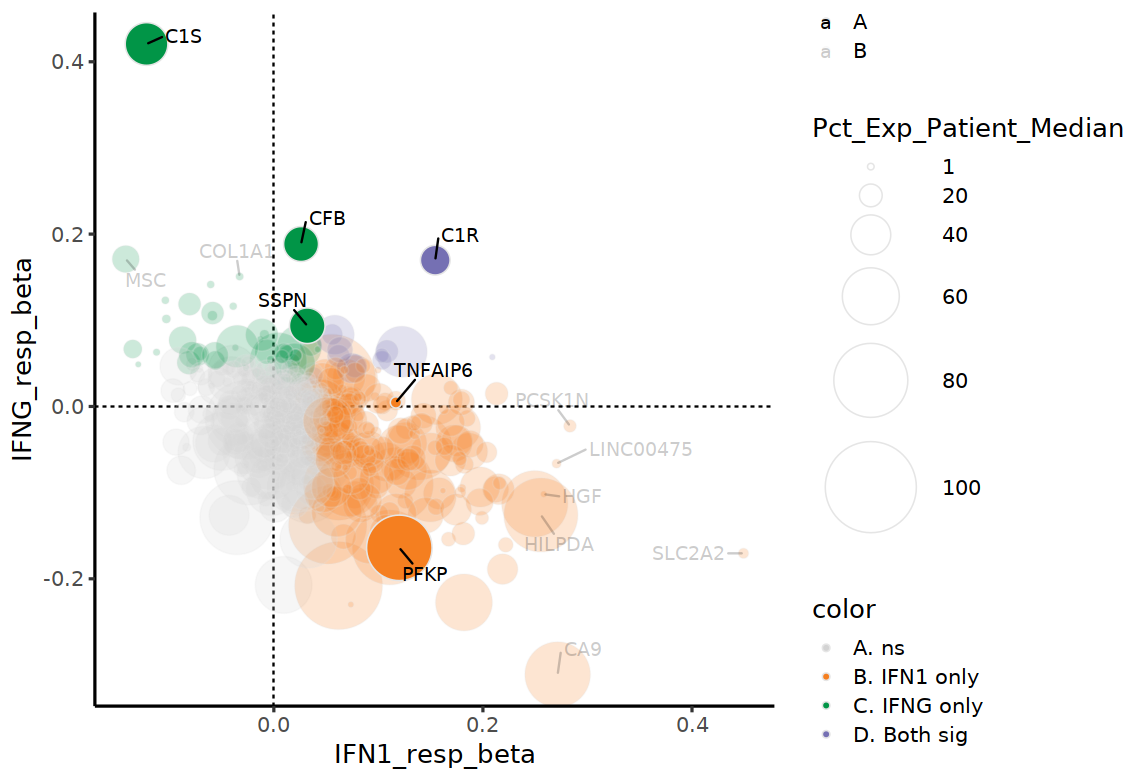

In [22]:
Tumor = readRDS("../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/Tumor_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
Tumor = subset(Tumor, gene %in% Reduced_Tumor_cts)
Tumor = left_join(Tumor, Tumor_stats, by = "gene")
head(Tumor)

up_IFN1 = subset(Tumor, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(Tumor, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(Tumor, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(Tumor, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


Tumor = mutate(Tumor, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
Tumor = mutate(Tumor, label = ifelse(gene %in% c(Tumor_IFN1, Tumor_IFNG) | IFN1_resp_beta > 0.25 | IFNG_resp_beta > 0.15 | IFN1_resp_beta > 0.1 & IFNG_resp_beta > 0.1 ,gene,""))
Tumor = mutate(Tumor, alpha = ifelse(gene %in% c(Tumor_IFN1, Tumor_IFNG),"A","B"))
#head(Tumor)
table(Tumor$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(Tumor %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) 
#ylim(c(-0.22,0.225)) +
#xlim(c(-0.075,0.17))
ggsave("../Figures/Figure3/Figure_3B_Tumor_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

,IFN1_resp_beta,IFNG_resp_beta,IFN1_resp_pval,IFNG_resp_pval,gene,IFN1_resp_p_adj_BH,IFNG_resp_p_adj_BH,IFN1_resp_p_adj_Bonf,IFNG_resp_p_adj_Bonf,Total_Pct_Expressing,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.133742265,0.05608249,1.210216e-142,6.174987e-28,OASL,1.877086e-140,3.210993e-26,1.088710e-138,5.555019e-24,27.673742,28.731847,1.1134898,27.95073,1.0054273
2,-0.025039602,0.14344333,1.474529e-06,1.302630e-174,CCL5,1.884213e-05,1.171846e-171,1.326486e-02,1.171846e-170,96.385542,96.316020,46.4758132,95.94592,45.6672009
3,-0.021538275,0.12628728,4.924414e-05,9.649089e-131,GZMA,5.080279e-04,7.233601e-128,4.430003e-01,8.680321e-127,90.751987,88.936452,16.3981236,89.30830,16.4570767
4,-0.010545879,0.04102943,4.996429e-02,5.577710e-15,IL2RB,2.031083e-01,1.229830e-13,1.000000e+00,5.017708e-11,33.106169,35.826852,1.4234536,34.60608,1.4397462
5,0.003749256,0.01279415,4.892130e-01,1.560343e-02,KLRK1,7.861176e-01,6.596260e-02,1.000000e+00,1.000000e+00,6.086583,6.963792,0.2210498,5.86298,0.2107759
6,0.034494761,0.04859056,1.519650e-10,2.427047e-20,NLRC5,2.927360e-09,8.270345e-19,1.367077e-06,2.183371e-16,21.604733,21.862130,0.8110755,21.24136,0.7910925



       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         106           17           84           15 

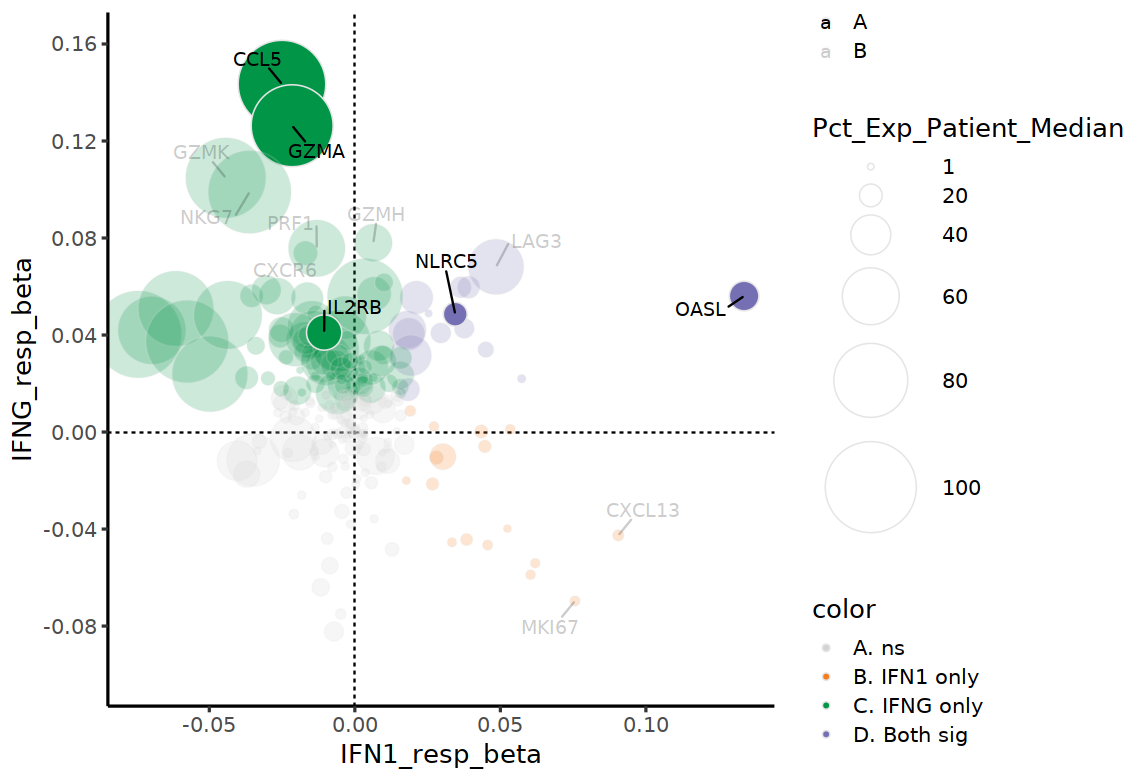

In [23]:
CD8 = readRDS("../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/CD8_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
CD8 = subset(CD8, gene %in% Reduced_CD8_cts)
CD8 = left_join(CD8, CD8_stats, by = "gene")
head(CD8)

up_IFN1 = subset(CD8, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(CD8, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(CD8, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(CD8, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


CD8 = mutate(CD8, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
CD8 = mutate(CD8, label = ifelse(gene %in% c(CD8_IFN1, CD8_IFNG) | IFN1_resp_beta > 0.07 | IFNG_resp_beta > 0.07 | IFN1_resp_beta > 0.04 & IFNG_resp_beta > 0.04 ,gene,""))
CD8 = mutate(CD8, alpha = ifelse(gene %in% c(CD8_IFN1, CD8_IFNG),"A","B"))
#head(CD8)
table(CD8$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(CD8 %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) +
scale_y_continuous(limits = c(-0.1,0.16), breaks = seq(-1, 0.16, by = 0.04))
#xlim(c(-0.075,0.17))
ggsave("../Figures/Figure3/Figure_3B_CD8_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

,IFN1_resp_beta,IFNG_resp_beta,IFN1_resp_pval,IFNG_resp_pval,gene,IFN1_resp_p_adj_BH,IFNG_resp_p_adj_BH,IFN1_resp_p_adj_Bonf,IFNG_resp_p_adj_Bonf,Total_Pct_Expressing,Pct_Exp_Sample_Median,Avg_Exp_Sample_Median,Pct_Exp_Patient_Median,Avg_Exp_Patient_Median
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.09569134,0.085715845,2.669829e-25,9.012632e-22,CCL5,2.693632e-23,3.593894e-19,2.235715e-21,7.547178e-18,50.31370,55.84147,7.3095098,52.92521,7.3095098
2,0.10942866,0.079948827,5.974209e-32,8.233832e-19,GZMA,7.250439e-30,2.089397e-16,5.002803e-28,6.895011e-15,46.88436,48.70103,5.0790932,44.17863,4.9601960
3,0.04662200,-0.005882456,1.672146e-06,5.357555e-01,IL2RB,3.889597e-05,8.505225e-01,1.400255e-02,1.000000e+00,15.59247,18.12296,0.6225564,17.73912,0.5853828
4,0.03519225,0.049623490,3.069058e-04,1.674756e-07,NLRC5,4.115091e-03,9.540413e-06,1.000000e+00,1.402441e-03,17.65293,15.92208,0.4971775,16.09154,0.4933230
5,0.01756535,0.035817841,6.330011e-02,9.734836e-05,SOCS1,2.679854e-01,2.801358e-03,1.000000e+00,8.151952e-01,29.82319,32.77349,1.1833331,34.06056,1.3210528
6,0.03913889,0.005257803,5.662026e-05,5.781971e-01,STAT4,9.520845e-04,8.705327e-01,4.741381e-01,1.000000e+00,32.88892,33.65949,1.3924194,33.33333,1.2065157



       A. ns B. IFN1 only C. IFNG only  D. Both sig 
         127           27            8            8 

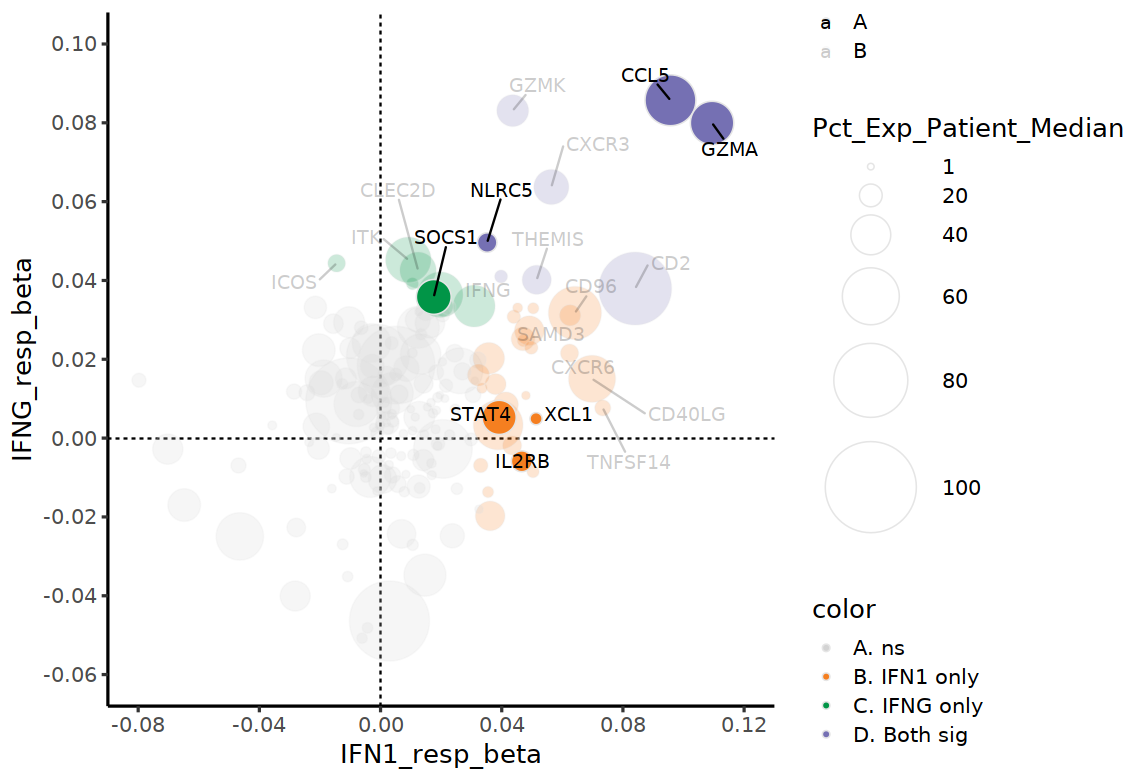

In [24]:
T_Helper = readRDS("../Outputs/Manuscript_MixedEffects_Output_Stage_Corrected_EarlyLate/T-Helper_CytoSig_MixedEffects_Patient_Stage_Corrected_EarlyLate_Vargenes.RDS")
T_Helper = subset(T_Helper, gene %in% Reduced_T_Helper_cts)
T_Helper = left_join(T_Helper, T_Helper_stats, by = "gene")
head(T_Helper)

up_IFN1 = subset(T_Helper, IFN1_resp_p_adj_BH < 0.01 & IFN1_resp_beta > 0)$gene
up_IFNG = subset(T_Helper, IFNG_resp_p_adj_BH < 0.01 & IFNG_resp_beta > 0)$gene
up_IFN1_only = setdiff(up_IFN1, up_IFNG)
up_IFNG_only = setdiff(up_IFNG, up_IFN1)
up_both = intersect(up_IFN1, up_IFNG)
ns_IFN1 = subset(T_Helper, IFN1_resp_beta < 0 | (IFN1_resp_beta > 0 & IFN1_resp_p_adj_BH > 0.01))$gene
ns_IFNG = subset(T_Helper, IFNG_resp_beta < 0 | (IFNG_resp_beta > 0 & IFNG_resp_p_adj_BH > 0.01))$gene
ns_both = intersect(ns_IFN1, ns_IFNG)


T_Helper = mutate(T_Helper, color = ifelse(gene %in% ns_both,"A. ns",ifelse(gene %in% up_IFN1_only ,"B. IFN1 only",ifelse(gene %in% up_IFNG_only,"C. IFNG only",ifelse(gene %in% up_both ,"D. Both sig","None")))))
T_Helper = mutate(T_Helper, label = ifelse(gene %in% c(T_Helper_IFN1, T_Helper_IFNG) | IFN1_resp_beta > 0.06 | IFNG_resp_beta > 0.04 | IFN1_resp_beta > 0.05 & IFNG_resp_beta > 0.05 ,gene,""))
T_Helper = mutate(T_Helper, alpha = ifelse(gene %in% c(T_Helper_IFN1, T_Helper_IFNG),"A","B"))
#head(T_Helper)
table(T_Helper$color)

options(repr.plot.width=9.5, repr.plot.height=6.5)
ggplot(T_Helper %>% arrange(label), aes(y=IFNG_resp_beta, x=IFN1_resp_beta,label = label,fill = color,alpha = alpha)) + 
geom_vline(xintercept = 0,linetype = "dashed") +
geom_hline(yintercept = 0,linetype = "dashed")+
geom_point(aes(size = Pct_Exp_Patient_Median, alpha = alpha),shape = 21,color = "grey90") + theme_classic(base_size = 15) + 
scale_radius(range = c(1, 25),breaks = c(1,20,40,60,80,100),limits = c(0,100)) +
geom_text_repel(max.overlaps = Inf,box.padding = 0.7, color = "black",segment.color = "black") +
scale_alpha_manual(values = c(1, 0.2)) +
scale_fill_manual(values = c("lightgrey","#F57F20","#019547","#7570b3","black")) +
scale_y_continuous(limits = c(-0.06,0.1), breaks = seq(-0.06, 0.1, by = 0.02)) +
scale_x_continuous(limits = c(-0.08,0.12), breaks = seq(-0.08, 0.12, by = 0.04))
#xlim(c(-0.075,0.17))
ggsave("../Figures/Figure3/Figure_3B_T_Helper_CTS_ISG_Scatter_w95_h65.pdf",width = 9.5, height = 6.5)

### Score cells for cell type-specific ISG signatures for visualization purposes <a name="2"></a>

### Rscripts/seur_full_notx_allstages_ISG_sigs_hacksig_zscore.R

In [ ]:
library(Seurat)
library(hacksig)
library(useful)

options(future.globals.maxSize= 100000*1024^2)

seur_full_notx_allstages = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

res = hack_sig(
  as.matrix(seur_full_notx_allstages@assays$RNA@data),
  signatures = ISG_sigs,
  method = "zscore")
head(res)

saveRDS(res, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Figures/Figure3/seur_full_notx_allstages_ISG_sigs_hacksig_zscore_scores.RDS")

### Define IFNG and IFN1 response high and low cells using CytoSig p-values for visualization purposes <a name="3"></a>

In [126]:
seur_full_notx_allstages = readRDS("../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript.RDS")
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"

goi = readRDS("../Signatures/manuscript_goi_hallmark_benciminn_curated.RDS")
length(goi)
length(unique(goi))

[1] 259

[1] 259

### Add ISG signature scores to metadata

In [129]:
res = data.frame(readRDS("../Figures/Figure3/seur_full_notx_allstages_ISG_sigs_hacksig_zscore_scores.RDS"))
res$barcode = res$sample_id
corner(res)

,sample_id,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,GTTCTCGAGAGGTAGA-1.5pool1_2,-1.0072653,-0.7190173,0.9040048,-0.7520046
2,CTAGAGTCATCAGTCA-1.5pool1_2,-0.7157719,-1.6249262,1.0402861,-0.8006176
3,CGGCTAGAGGTAGCCA-1.5pool1_2,-1.0072653,-1.6249262,-0.4297300,-1.0555212
4,CTGCTGTAGTGTTTGC-1.5pool1_2,-1.0072653,-1.6249262,3.3532442,-1.0555212
5,CCATGTCCATCGATGT-1.5pool1_2,-1.0072653,-1.6249262,2.2167324,-0.6502795


In [130]:
meta = seur_full_notx_allstages@meta.data
meta$barcode= row.names(meta)

meta_sig = left_join(meta, res, by = "barcode")
row.names(meta_sig) = row.names(meta)
corner(meta_sig)

seur_full_notx_allstages@meta.data = meta_sig

,orig.ident,nCount_RNA,nFeature_RNA,Sample,cell_id
,<fct>,<dbl>,<int>,<chr>,<chr>
GTTCTCGAGAGGTAGA-1.5pool1_2,SeuratProject,17633,4215,5pool1_2,GTTCTCGAGAGGTAGA-1.5pool1_2
CTAGAGTCATCAGTCA-1.5pool1_2,SeuratProject,14519,4068,5pool1_2,CTAGAGTCATCAGTCA-1.5pool1_2
CGGCTAGAGGTAGCCA-1.5pool1_2,SeuratProject,14443,3521,5pool1_2,CGGCTAGAGGTAGCCA-1.5pool1_2
CTGCTGTAGTGTTTGC-1.5pool1_2,SeuratProject,12982,3884,5pool1_2,CTGCTGTAGTGTTTGC-1.5pool1_2
CCATGTCCATCGATGT-1.5pool1_2,SeuratProject,12169,3542,5pool1_2,CCATGTCCATCGATGT-1.5pool1_2


In [133]:
subset(data.frame(table(colnames(seur_full_notx_allstages@meta.data))), Freq != 1)

Var1,Freq
<fct>,<int>


### Add CytoSig scores to metadata

In [134]:
cytosig_binded_df = readRDS("../Data_Objects/cytosig_binded_df_seur_full_notx_allstages.RDS")

length(intersect(row.names(cytosig_binded_df),row.names(seur_full_notx_allstages@meta.data)))
length(row.names(seur_full_notx_allstages@meta.data))

cytosig_binded_df_ordered = cytosig_binded_df[row.names(seur_full_notx_allstages@meta.data),]
dim(cytosig_binded_df_ordered)

[1] 143381

[1] 143381

[1] 143381     86

In [135]:
min(cytosig_binded_df_ordered)
max(cytosig_binded_df_ordered)

[1] -18.79981

[1] 23.98243

In [136]:
seur_full_notx_allstages@meta.data = cbind(seur_full_notx_allstages@meta.data, cytosig_binded_df_ordered)

### Define IFN1 and IFNG response high and low (CytoSig_Zscore > 0 and CytoSig_Pval < 0.05) 

In [138]:
metamut = seur_full_notx_allstages@meta.data

metamut = mutate(metamut, Figure3_IFN1_Pheno = ifelse(IFN1_CytoSig_Zscore > 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_High",ifelse(IFN1_CytoSig_Zscore < 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_Low","IFN1_NA")))
metamut = mutate(metamut, Figure3_IFNG_Pheno = ifelse(IFNG_CytoSig_Zscore > 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_High",ifelse(IFNG_CytoSig_Zscore < 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_Low","IFNG_NA")))

table(metamut$Figure3_IFN1_Pheno)
table(metamut$Figure3_IFNG_Pheno)

row.names(metamut) = row.names(seur_full_notx_allstages@meta.data)


IFN1_High  IFN1_Low   IFN1_NA 
    14668     16820    111893 


IFNG_High  IFNG_Low   IFNG_NA 
    18184     18861    106336 

In [139]:
seur_full_notx_allstages$Figure3_IFN1_Pheno = metamut$Figure3_IFN1_Pheno
seur_full_notx_allstages$Figure3_IFNG_Pheno = metamut$Figure3_IFNG_Pheno

In [140]:
plot_df_IFNG = subset(seur_full_notx_allstages,subset = Figure3_IFNG_Pheno != "IFNG_NA")@meta.data
plot_df_IFNG$Figure3_IFNG_Pheno = factor(plot_df_IFNG$Figure3_IFNG_Pheno, levels = c("IFNG_Low","IFNG_High"))

plot_df_IFN1 = subset(seur_full_notx_allstages,subset = Figure3_IFN1_Pheno != "IFN1_NA")@meta.data
plot_df_IFN1$Figure3_IFN1_Pheno = factor(plot_df_IFN1$Figure3_IFN1_Pheno, levels = c("IFN1_Low","IFN1_High"))

In [56]:
saveRDS(seur_full_notx_allstages, file = "../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript_ISGscores_IFNhilow.RDS")

### Heatmap of type I and type II cell type-specific ISGs <a name="4"></a>

In [8]:
seur_full_notx_allstages = readRDS(file = "../Data_Objects/seur_full_BBK_notx_allstages_No_Omitted_Contam_Manuscript_ISGscores_IFNhilow.RDS")

goi = readRDS("../Signatures/manuscript_goi_hallmark_benciminn_curated.RDS")
length(goi)
length(unique(goi))

[1] 259

[1] 259

In [9]:
ISG_sigs = readRDS("../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")

In [10]:
celltype_cols = readRDS(file = "../Data_Objects//celltype_cols.RDS")
celltype_cols

celltype_cols_DE = celltype_cols
names(celltype_cols_DE) = replace(names(celltype_cols_DE), names(celltype_cols_DE) == "Perivascular cell","Perivascular.and.Fibroblast")
celltype_cols_DE = celltype_cols_DE[unique(as.character(seur_full_notx_allstages@meta.data$BBK_Broad_Celltype_DE))]
celltype_cols_DE["Perivascular.and.Fibroblast"] = "#766458"
celltype_cols_DE

Tumor               TAM               CD8       Plasma cell 
        "#A0BAAC"         "#7FC97F"         "#C2AFCE"         "#E4B9A3" 
               DC       Endothelial          T-Helper                NK 
        "#FDC988"         "#FEEB93"         "#D1DD9E"         "#658DAA" 
         Monocyte             T-reg            B cell       CD8 NK-like 
        "#704BA0"         "#D31286"         "#DD2456"         "#C2541E" 
       Fibroblast Perivascular cell            Contam           Omitted 
        "#95603B"         "#666666"          "grey95"          "grey95"

Tumor                    Monocyte 
                  "#A0BAAC"                   "#704BA0" 
                        TAM                         CD8 
                  "#7FC97F"                   "#C2AFCE" 
                Plasma cell                 CD8 NK-like 
                  "#E4B9A3"                   "#C2541E" 
                         DC                 Endothelial 
                  "#FDC988"                   "#FEEB93" 
                      T-reg                          NK 
                  "#D31286"                   "#658DAA" 
                   T-Helper                      B cell 
                  "#D1DD9E"                   "#DD2456" 
                       <NA> Perivascular.and.Fibroblast 
                         NA                   "#766458"

In [11]:
Idents(seur_full_notx_allstages) = "BBK_Broad_Celltype_DE"
seur_full_notx_allstages = RenameIdents(seur_full_notx_allstages,"Perivascular_and_Fibroblast"="Perivascular.and.Fibroblast")
Idents(seur_full_notx_allstages) = factor(Idents(seur_full_notx_allstages), levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))
seur_full_notx_allstages$BBK_Broad_Celltype_DE = Idents(seur_full_notx_allstages)

table(Idents(seur_full_notx_allstages))
table(seur_full_notx_allstages$BBK_Broad_Celltype_DE)


                      Tumor Perivascular.and.Fibroblast 
                      12921                         786 
                Endothelial                         TAM 
                       1127                       13929 
                   Monocyte                          DC 
                      11243                        2580 
                        CD8                 CD8 NK-like 
                      51211                       10928 
                         NK                    T-Helper 
                      17431                       14026 
                      T-reg                      B cell 
                       5106                        1592 
                Plasma cell 
                        501 


                      Tumor Perivascular.and.Fibroblast 
                      12921                         786 
                Endothelial                         TAM 
                       1127                       13929 
                   Monocyte                          DC 
                      11243                        2580 
                        CD8                 CD8 NK-like 
                      51211                       10928 
                         NK                    T-Helper 
                      17431                       14026 
                      T-reg                      B cell 
                       5106                        1592 
                Plasma cell 
                        501 

Centering and scaling data matrix



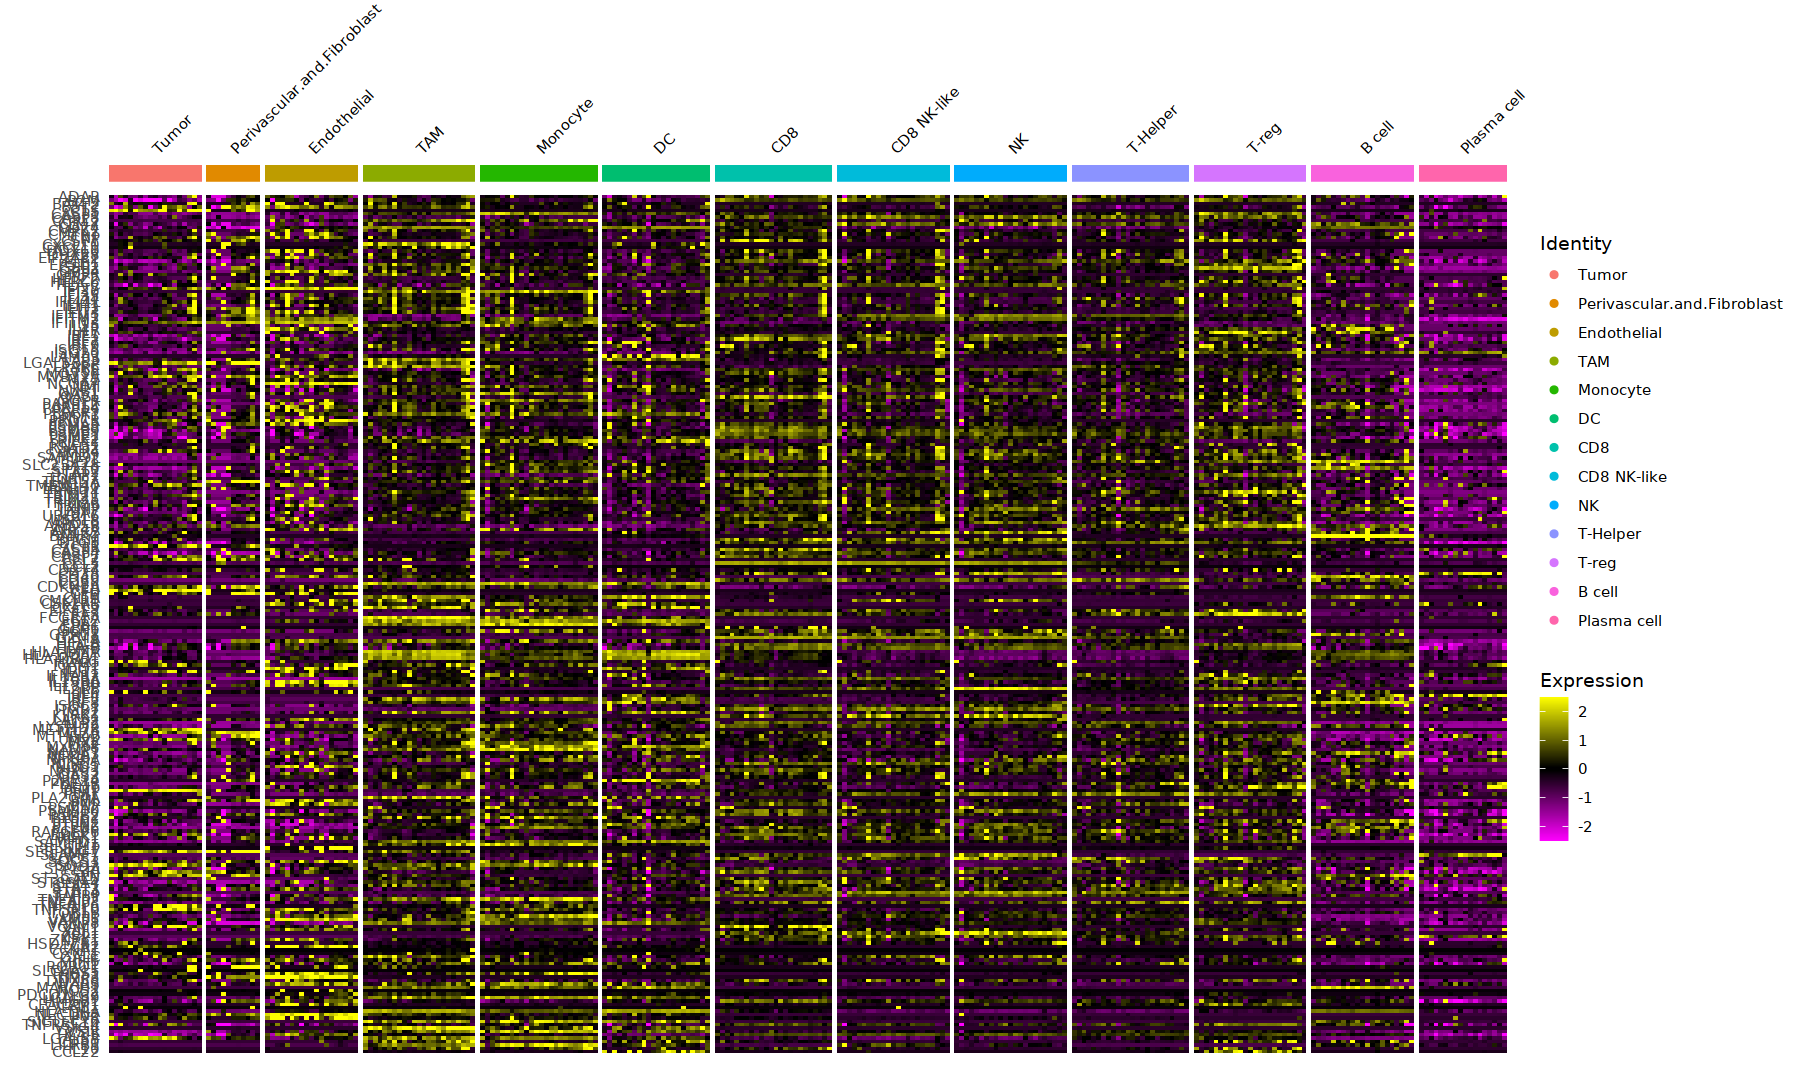

In [12]:
options(repr.plot.width=15, repr.plot.height=9)

seur_full_notx_allstages$Sample = factor(seur_full_notx_allstages$Sample)
seur_full_notx_allstages$Cohort = factor(seur_full_notx_allstages$Cohort)

seur_full_notx_allstages$BBK_Broad_Celltype_DE_Sample = paste(seur_full_notx_allstages$BBK_Broad_Celltype_DE,seur_full_notx_allstages$Sample,sep = "_")

cluster.averages <- AverageExpression(seur_full_notx_allstages, return.seurat = TRUE, group.by = c("BBK_Broad_Celltype_DE","Sample"))
Idents(cluster.averages) = factor(Idents(cluster.averages), levels = levels(Idents(seur_full_notx_allstages)))

DoHeatmap(cluster.averages, features = intersect(goi, row.names(seur_full_notx_allstages@assays$RNA@data)), size = 3, 
    draw.lines = TRUE)

In [13]:
head(cluster.averages@meta.data)
cluster.averages$BBK_Broad_Celltype_DE_Sample = row.names(cluster.averages@meta.data)
cluster.averages@meta.data = left_join(cluster.averages@meta.data, distinct(seur_full_notx_allstages@meta.data[,c("Cohort","Sample","Stage_Corrected","Biopsy","IO_Treated","BBK_Broad_Celltype_DE_Sample","BBK_Broad_Celltype_DE")]),by = "BBK_Broad_Celltype_DE_Sample")
row.names(cluster.averages@meta.data) = cluster.averages$BBK_Broad_Celltype_DE_Sample
head(cluster.averages@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
Tumor_5pool1_2,Tumor,10000,18069
Tumor_Bi_0600916_T1,Tumor,10000,3093
Tumor_Bi_DFCI_0600876_T1,Tumor,10000,21445
Tumor_Bi_DFCI_0600890_T1,Tumor,10000,25586
Tumor_Pool70-10,Tumor,10000,12026
Tumor_Pool70-6,Tumor,10000,16561


,orig.ident,nCount_RNA,nFeature_RNA,BBK_Broad_Celltype_DE_Sample,Cohort,Sample,Stage_Corrected,Biopsy,IO_Treated,BBK_Broad_Celltype_DE
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>
Tumor_5pool1_2,Tumor,10000,18069,Tumor_5pool1_2,Braun,5pool1_2,I,Kidney,IO Naive,Tumor
Tumor_Bi_0600916_T1,Tumor,10000,3093,Tumor_Bi_0600916_T1,Bi,Bi_0600916_T1,IV,Lymph_node,IO Naive,Tumor
Tumor_Bi_DFCI_0600876_T1,Tumor,10000,21445,Tumor_Bi_DFCI_0600876_T1,Bi,Bi_DFCI_0600876_T1,IV,Kidney,IO Naive,Tumor
Tumor_Bi_DFCI_0600890_T1,Tumor,10000,25586,Tumor_Bi_DFCI_0600890_T1,Bi,Bi_DFCI_0600890_T1,I,Kidney,IO Naive,Tumor
Tumor_Pool70-10,Tumor,10000,12026,Tumor_Pool70-10,Braun,Pool70-10,IV,Adrenal,IO Naive,Tumor
Tumor_Pool70-6,Tumor,10000,16561,Tumor_Pool70-6,Braun,Pool70-6,I,Kidney,IO Naive,Tumor


In [14]:
ISG_sigs_plot = unique(c(ISG_sigs$manuscript_IFNG_tumor,ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_myeloid,ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_t_nk,ISG_sigs$manuscript_IFN1_t_nk))
ISG_sigs_plot

[1] "C1S"      "C1R"      "CFB"      "SSPN"     "PFKP"     "TNFAIP6" 
 [7] "CD86"     "FCGR1A"   "FPR1"     "MYD88"    "SIGLEC10" "LILRB1"  
[13] "SECTM1"   "JAK2"     "CXCL10"   "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "GCH1"     "MX2"      "LAMP3"    "NFKB1"    "IFI30"   
[25] "LPAR6"    "VSIG4"    "IL10"     "CCL5"     "GZMA"     "IL2RB"   
[31] "NLRC5"    "OASL"     "STAT4"    "SOCS1"    "XCL1"

In [15]:
setdiff(ISG_sigs$manuscript_IFN1_tumor,ISG_sigs$manuscript_IFNG_tumor)
setdiff(ISG_sigs$manuscript_IFNG_tumor,ISG_sigs$manuscript_IFN1_tumor)

[1] "PFKP"    "TNFAIP6"

[1] "C1S"  "CFB"  "SSPN"

In [16]:
setdiff(ISG_sigs$manuscript_IFN1_myeloid,ISG_sigs$manuscript_IFNG_myeloid)
setdiff(ISG_sigs$manuscript_IFNG_myeloid,ISG_sigs$manuscript_IFN1_myeloid)

[1] "IFI30" "LPAR6" "VSIG4" "IL10"

[1] "FPR1"    "JAK2"    "CXCL9"   "TNFAIP2" "PTGS2"   "IL15"    "LAMP3"  
[8] "NFKB1"

In [17]:
setdiff(ISG_sigs$manuscript_IFN1_t_nk,ISG_sigs$manuscript_IFNG_t_nk)
setdiff(ISG_sigs$manuscript_IFNG_t_nk,ISG_sigs$manuscript_IFN1_t_nk)

[1] "XCL1"

[1] "SOCS1"

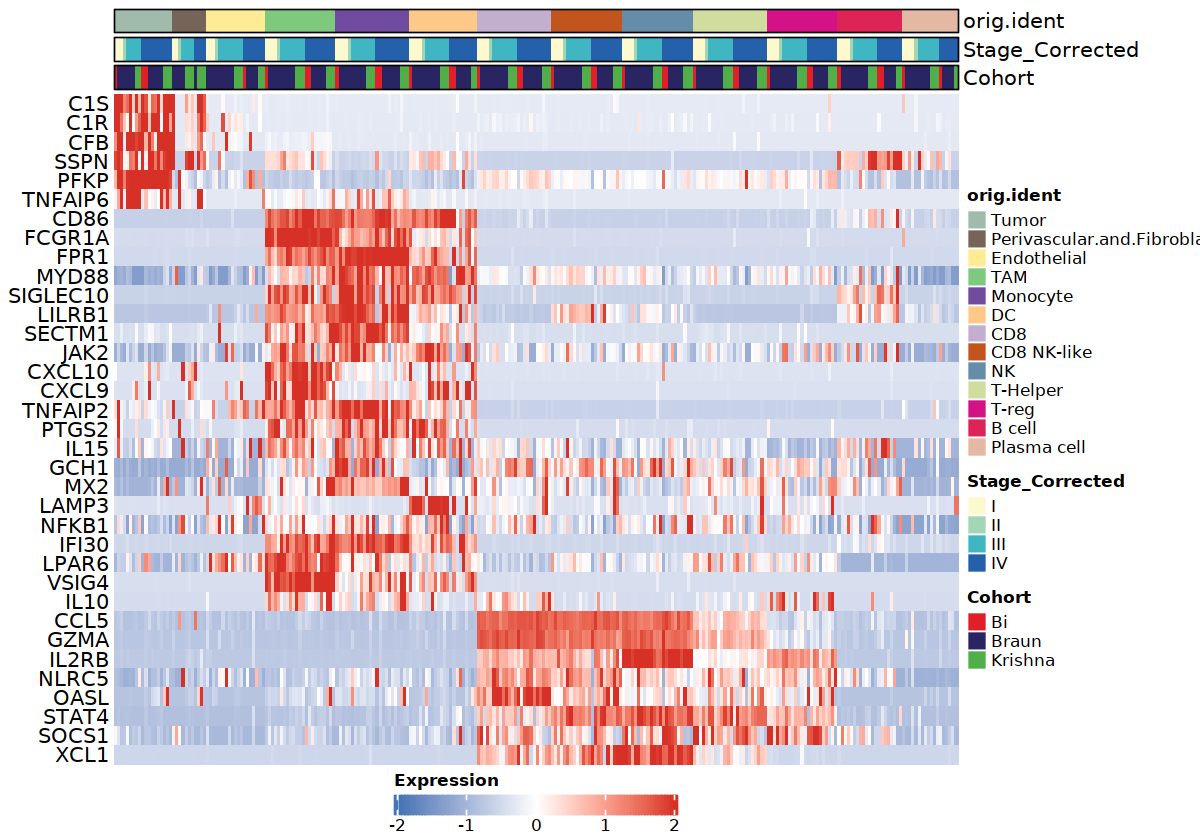

In [18]:
cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=10, repr.plot.height=7)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = ISG_sigs_plot,
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors)

In [19]:
pdf("../Figures/Figure3/Figure3C_ISG_Heatmap.pdf", width = 10, height = 7, useDingbats = F)

cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=10, repr.plot.height=7)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = ISG_sigs_plot,
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors)

dev.off()

png 
  2

### Make heatmap of ISG signature scores

In [21]:
meta = seur_full_notx_allstages@meta.data

agg_tbl <- meta %>% group_by(BBK_Broad_Celltype_DE_Sample) %>% 
  summarise(median_manuscript_IFNG_tumor=median(manuscript_IFNG_tumor),
            median_manuscript_IFNG_myeloid=median(manuscript_IFNG_myeloid),
            median_manuscript_IFNG_t_nk=median(manuscript_IFNG_t_nk),
            median_manuscript_IFN1_tumor=median(manuscript_IFN1_tumor),
            median_manuscript_IFN1_myeloid=median(manuscript_IFN1_myeloid),
            median_manuscript_IFN1_t_nk=median(manuscript_IFN1_t_nk),
            .groups = 'drop')

In [23]:
head(agg_tbl)
length(intersect(agg_tbl$BBK_Broad_Celltype_DE_Sample,row.names(cluster.averages@meta.data)))

agg_tbl = data.frame(agg_tbl)
row.names(agg_tbl) = agg_tbl$BBK_Broad_Celltype_DE_Sample

agg_tbl = agg_tbl[row.names(cluster.averages@meta.data),]
head(agg_tbl)

BBK_Broad_Celltype_DE_Sample,median_manuscript_IFNG_tumor,median_manuscript_IFNG_myeloid,median_manuscript_IFNG_t_nk,median_manuscript_IFN1_tumor,median_manuscript_IFN1_myeloid,median_manuscript_IFN1_t_nk
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B cell_5pool1_2,-0.4315981,-1.05552125,-1.681933,-0.42973,-1.0072653,-1.624926
B cell_Bi_0600916_T1,-0.4315981,-0.48661897,-1.681933,-0.42973,-0.3567007,-1.624926
B cell_Bi_DFCI_0600876_T1,-0.4315981,-0.17578879,-1.681933,-0.42973,-0.2333639,-1.624926
B cell_Bi_DFCI_0600890_T1,-0.4315981,-1.05552125,-1.681933,-0.42973,-1.0072653,-1.624926
B cell_Pool70-10,-0.4315981,-0.01084903,-1.456024,-0.42973,-0.3924785,-1.624926
B cell_Pool70-6,-0.4315981,-1.05552125,-1.681933,-0.42973,-1.0072653,-1.624926


[1] 274

,BBK_Broad_Celltype_DE_Sample,median_manuscript_IFNG_tumor,median_manuscript_IFNG_myeloid,median_manuscript_IFNG_t_nk,median_manuscript_IFN1_tumor,median_manuscript_IFN1_myeloid,median_manuscript_IFN1_t_nk
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tumor_5pool1_2,Tumor_5pool1_2,2.8574260,-0.007245101,-1.681933,1.703319,-1.007265,-1.624926
Tumor_Bi_0600916_T1,Tumor_Bi_0600916_T1,4.1964406,-1.055521249,-1.681933,2.372979,-1.007265,-1.624926
Tumor_Bi_DFCI_0600876_T1,Tumor_Bi_DFCI_0600876_T1,-0.4315981,-1.055521249,-1.681933,-0.429730,-1.007265,-1.624926
Tumor_Bi_DFCI_0600890_T1,Tumor_Bi_DFCI_0600890_T1,3.0313985,-1.055521249,-1.681933,1.510535,-1.007265,-1.624926
Tumor_Pool70-10,Tumor_Pool70-10,-0.4315981,-1.055521249,-1.681933,-0.429730,-1.007265,-1.624926
Tumor_Pool70-6,Tumor_Pool70-6,1.9329540,-1.055521249,-1.681933,1.506469,-1.007265,-1.624926


In [25]:
setequal(cluster.averages$BBK_Broad_Celltype_DE_Sample, agg_tbl$BBK_Broad_Celltype_DE_Sample)

[1] TRUE

In [26]:
cluster.averages$median_manuscript_IFNG_tumor = agg_tbl$median_manuscript_IFNG_tumor
cluster.averages$median_manuscript_IFNG_myeloid = agg_tbl$median_manuscript_IFNG_myeloid
cluster.averages$median_manuscript_IFNG_t_nk= agg_tbl$median_manuscript_IFNG_t_nk

cluster.averages$median_manuscript_IFN1_tumor = agg_tbl$median_manuscript_IFN1_tumor
cluster.averages$median_manuscript_IFN1_myeloid = agg_tbl$median_manuscript_IFN1_myeloid
cluster.averages$median_manuscript_IFN1_t_nk= agg_tbl$median_manuscript_IFN1_t_nk

In [27]:
sigmat = as.matrix(data.frame(t(scale(cluster.averages@meta.data[,c("median_manuscript_IFNG_tumor","median_manuscript_IFNG_myeloid","median_manuscript_IFNG_t_nk","median_manuscript_IFN1_tumor","median_manuscript_IFN1_myeloid","median_manuscript_IFN1_t_nk")])), check.names = F))
length(intersect(colnames(sigmat), row.names(cluster.averages@meta.data)))
setdiff(colnames(sigmat), row.names(cluster.averages@meta.data))
setdiff(row.names(cluster.averages@meta.data),colnames(sigmat))

[1] 274

character(0)

character(0)

In [28]:
cluster.averages@assays$RNA@data = sigmat
cluster.averages@assays$RNA@scale.data = sigmat
corner(cluster.averages@assays$RNA@scale.data)

,Tumor_5pool1_2,Tumor_Bi_0600916_T1,Tumor_Bi_DFCI_0600876_T1,Tumor_Bi_DFCI_0600890_T1,Tumor_Pool70-10
median_manuscript_IFNG_tumor,2.70480102,3.9148630,-0.2674764,2.8620193,-0.2674764
median_manuscript_IFNG_myeloid,0.03805505,-0.7044065,-0.7044065,-0.7044065,-0.7044065
median_manuscript_IFNG_t_nk,-0.84598412,-0.8459841,-0.8459841,-0.8459841,-0.8459841
median_manuscript_IFN1_tumor,2.53946607,3.4282721,-0.2916226,2.2835929,-0.2916226
median_manuscript_IFN1_myeloid,-0.63956959,-0.6395696,-0.6395696,-0.6395696,-0.6395696


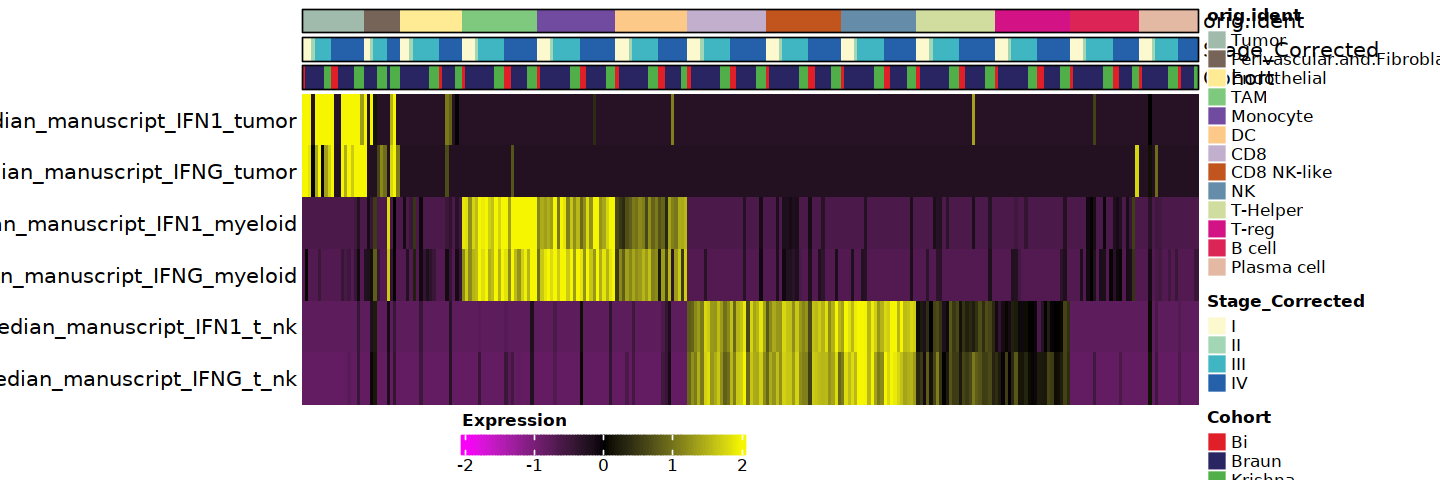

In [31]:
cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=12, repr.plot.height=4)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = c("median_manuscript_IFN1_tumor","median_manuscript_IFNG_tumor","median_manuscript_IFN1_myeloid","median_manuscript_IFNG_myeloid","median_manuscript_IFN1_t_nk","median_manuscript_IFNG_t_nk"),
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors,hm_colors = c("#F900F9","black","#F6F600"))

In [32]:
pdf("../Figures/Figure3/Figure3C_ISG_Signatures_Heatmap.pdf", width = 12, height = 4, useDingbats = F)

cluster.averages$orig.ident = factor(cluster.averages$orig.ident, levels = c("Tumor","Perivascular.and.Fibroblast","Endothelial","TAM","Monocyte","DC","CD8","CD8 NK-like","NK","T-Helper","T-reg","B cell","Plasma cell"))

options(repr.plot.width=12, repr.plot.height=7)
colors <- list(celltype_cols_DE[levels(cluster.averages$orig.ident)], c("#FCF9CF","#A3D6B4","#41B6C3","#2560AA"),c("#E11F28","#292562","#50AF48"))

DefaultAssay(cluster.averages) = "RNA"
plot_heatmap(dataset = cluster.averages, 
              markers = c("median_manuscript_IFN1_tumor","median_manuscript_IFNG_tumor","median_manuscript_IFN1_myeloid","median_manuscript_IFNG_myeloid","median_manuscript_IFN1_t_nk","median_manuscript_IFNG_t_nk"),
              sort_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_var = c("orig.ident","Stage_Corrected","Cohort"),
              anno_colors = colors,hm_colors = c("#F900F9","black","#F6F600"))

dev.off()

png 
  2

### Figure 3C and 3D. Violin plots of ISG signature scores in IFN1 and IFNG response high and low cells in samples from treated patients <a name="5"></a>

### Score cells from treated patients with ISG signatures

### Rscripts/seur_full_treated_ISG_Sigs_hacksig_zscore.R

In [ ]:
library(Seurat)
library(hacksig)
library(useful)

options(future.globals.maxSize= 100000*1024^2)

seur_full = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_Manuscript.RDS")
Idents(seur_full) = "BBK_Broad_Celltype_DE"

seur_full = subset(seur_full, idents = c("Contam","Omitted"), invert = T)

seur_full_treated = subset(seur_full, subset = IO_Treated == "IO Exposed" )
seur_full_treated

ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

res = hack_sig(
  as.matrix(seur_full_treated@assays$RNA@data),
  signatures = ISG_sigs,
  method = "zscore")
head(res)

saveRDS(res, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Figures/Figure3/seur_full_treated_ISG_Sigs_scores_hacksig_zscore.RDS")

### Retrieve treated subset

In [26]:
seur_full = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Data_Objects/seur_full_BBK_Manuscript.RDS")
seur_full

Idents(seur_full) = "BBK_Broad_Celltype_DE"

seur_full = subset(seur_full, idents = c("Contam","Omitted"), invert = T)

seur_full_treated = subset(seur_full, subset = IO_Treated == "IO Exposed" )
seur_full_treated

table(seur_full_treated$BBK_Broad_Celltype_DE)
table(Idents(seur_full_treated))

An object of class Seurat 
39619 features across 288768 samples within 1 assay 
Active assay: RNA (39619 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
39619 features across 84990 samples within 1 assay 
Active assay: RNA (39619 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap


                      Tumor Perivascular_and_Fibroblast 
                       6073                        1182 
                Endothelial                         TAM 
                        654                       13755 
                   Monocyte                          DC 
                       3829                        1942 
                        CD8                 CD8 NK-like 
                      37246                        2635 
                         NK                    T-Helper 
                       2991                        8630 
                      T-reg                      B cell 
                       3512                        1738 
                Plasma cell                      Contam 
                        803                           0 
                    Omitted 
                          0 


                      Tumor Perivascular_and_Fibroblast 
                       6073                        1182 
                Endothelial                         TAM 
                        654                       13755 
                   Monocyte                          DC 
                       3829                        1942 
                        CD8                 CD8 NK-like 
                      37246                        2635 
                         NK                    T-Helper 
                       2991                        8630 
                      T-reg                      B cell 
                       3512                        1738 
                Plasma cell 
                        803 

### Add ISG signature scores to metadata

In [27]:
ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [28]:
res = data.frame(readRDS("../Figures/Figure3/seur_full_treated_ISG_Sigs_scores_hacksig_zscore.RDS"))
res$barcode = res$sample_id
corner(res)

,sample_id,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAAGCAAAGTGGTCCC-1.Bi_0600855_T3,-0.8109736,-0.807697184,7.877889,-0.6022266
2,CCGGGATAGGTGATTA-1.Bi_0600855_T3,-0.5901006,0.001557434,8.372138,-0.5004433
3,TGAAAGACAAGGGTCA-1.Bi_0600855_T3,-0.4353556,-0.864965161,8.104624,-0.2540055
4,TTTGCGCAGCTGAACG-1.Bi_0600855_T3,-0.9035563,-1.421944314,5.557065,-0.9474470
5,CTACGTCCACATCTTT-1.Bi_0600855_T3,-1.0676160,-1.421944314,4.517918,-0.6154711


In [29]:
meta = seur_full_treated@meta.data
meta$barcode= row.names(meta)

meta_sig = left_join(meta, res, by = "barcode")
row.names(meta_sig) = row.names(meta)
corner(meta_sig)

seur_full_treated@meta.data = meta_sig

,orig.ident,nCount_RNA,nFeature_RNA,Sample,cell_id
,<fct>,<dbl>,<int>,<chr>,<chr>
AAAGCAAAGTGGTCCC-1.Bi_0600855_T3,SeuratProject,65967,7059,Bi_0600855_T3,AAAGCAAAGTGGTCCC-1.Bi_0600855_T3
CCGGGATAGGTGATTA-1.Bi_0600855_T3,SeuratProject,37778,6448,Bi_0600855_T3,CCGGGATAGGTGATTA-1.Bi_0600855_T3
TGAAAGACAAGGGTCA-1.Bi_0600855_T3,SeuratProject,37049,5646,Bi_0600855_T3,TGAAAGACAAGGGTCA-1.Bi_0600855_T3
TTTGCGCAGCTGAACG-1.Bi_0600855_T3,SeuratProject,32594,4799,Bi_0600855_T3,TTTGCGCAGCTGAACG-1.Bi_0600855_T3
CTACGTCCACATCTTT-1.Bi_0600855_T3,SeuratProject,30893,4946,Bi_0600855_T3,CTACGTCCACATCTTT-1.Bi_0600855_T3


### Add CytoSig scores to metadata

In [30]:
cytosig_binded_df = readRDS(file = "../Data_Objects/cytosig_binded_df_seur_full_treated.RDS")

length(intersect(row.names(cytosig_binded_df),row.names(seur_full_treated@meta.data)))
length(row.names(seur_full_treated@meta.data))

cytosig_binded_df_ordered = cytosig_binded_df[row.names(seur_full_treated@meta.data),]
dim(cytosig_binded_df_ordered)

[1] 84990

[1] 84990

[1] 84990    86

In [31]:
min(cytosig_binded_df_ordered)
max(cytosig_binded_df_ordered)

[1] -20.06902

[1] 20.98164

In [32]:
seur_full_treated@meta.data = cbind(seur_full_treated@meta.data, cytosig_binded_df_ordered)

### Define IFN1 and IFNG response high and low (CytoSig_Zscore > 0 and CytoSig_Pval < 0.05)

In [33]:
metamut = seur_full_treated@meta.data

metamut = mutate(metamut, Figure3_IFN1_Pheno = ifelse(IFN1_CytoSig_Zscore > 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_High",ifelse(IFN1_CytoSig_Zscore < 0 & IFN1_CytoSig_Pval < 0.05, "IFN1_Low","IFN1_NA")))
metamut = mutate(metamut, Figure3_IFNG_Pheno = ifelse(IFNG_CytoSig_Zscore > 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_High",ifelse(IFNG_CytoSig_Zscore < 0 & IFNG_CytoSig_Pval < 0.05, "IFNG_Low","IFNG_NA")))

table(metamut$Figure3_IFN1_Pheno)
table(metamut$Figure3_IFNG_Pheno)

row.names(metamut) = row.names(seur_full_treated@meta.data)


IFN1_High  IFN1_Low   IFN1_NA 
     8740      8045     68205 


IFNG_High  IFNG_Low   IFNG_NA 
    12899     13700     58391 

In [34]:
seur_full_treated$Figure3_IFN1_Pheno = metamut$Figure3_IFN1_Pheno
seur_full_treated$Figure3_IFNG_Pheno = metamut$Figure3_IFNG_Pheno

In [35]:
plot_df_IFNG = subset(seur_full_treated,subset = Figure3_IFNG_Pheno != "IFNG_NA")@meta.data
plot_df_IFNG$Figure3_IFNG_Pheno = factor(plot_df_IFNG$Figure3_IFNG_Pheno, levels = c("IFNG_Low","IFNG_High"))

plot_df_IFN1 = subset(seur_full_treated,subset = Figure3_IFN1_Pheno != "IFN1_NA")@meta.data
plot_df_IFN1$Figure3_IFN1_Pheno = factor(plot_df_IFN1$Figure3_IFN1_Pheno, levels = c("IFN1_Low","IFN1_High"))

In [36]:
signif_cutoffs = list(cutpoints = c(0, 0.001, 0.01, 0.05, Inf), symbols = c("***", "**", "*", "ns"))

In [37]:
plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_Myeloid = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("TAM","Monocyte","DC"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid, levels = c("TAM","Monocyte","DC","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_Myeloid)

plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_Tumor = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("Tumor","Perivascular_and_Fibroblast"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor, levels = c("Tumor","Perivascular_and_Fibroblast","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_Tumor)

plot_df_IFNG = mutate(plot_df_IFNG, BBK_Broad_Celltype_DE_T_NK = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("CD8","CD8 NK-like","NK","T-Helper","T-reg"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK = factor(plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK, levels = c("CD8","CD8 NK-like","NK","T-Helper","T-reg","Other"))
table(plot_df_IFNG$BBK_Broad_Celltype_DE_T_NK)


     TAM Monocyte       DC    Other 
    8017     1481      892    16209 


                      Tumor Perivascular_and_Fibroblast 
                       2105                         443 
                      Other 
                      24051 


        CD8 CD8 NK-like          NK    T-Helper       T-reg       Other 
       9037         590         580        1834         906       13652 

In [38]:
plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_Myeloid = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("TAM","Monocyte","DC"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid, levels = c("TAM","Monocyte","DC","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_Myeloid)

plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_Tumor = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("Tumor","Perivascular_and_Fibroblast"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor, levels = c("Tumor","Perivascular_and_Fibroblast","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_Tumor)

plot_df_IFN1 = mutate(plot_df_IFN1, BBK_Broad_Celltype_DE_T_NK = ifelse(as.character(BBK_Broad_Celltype_DE) %in% c("CD8","CD8 NK-like","NK","T-Helper","T-reg"),as.character(BBK_Broad_Celltype_DE),"Other"))
plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK = factor(plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK, levels = c("CD8","CD8 NK-like","NK","T-Helper","T-reg","Other"))
table(plot_df_IFN1$BBK_Broad_Celltype_DE_T_NK)


     TAM Monocyte       DC    Other 
    4906     1039      505    10335 


                      Tumor Perivascular_and_Fibroblast 
                       1675                         398 
                      Other 
                      14712 


        CD8 CD8 NK-like          NK    T-Helper       T-reg       Other 
       5503         292         265         968         520        9237 

### Calculate median IFNG score per sample, grouped down by Sample and IFNG response high and low

In [39]:
plot_df_IFNG$Figure3_IFNG_Pheno_Sample = paste(plot_df_IFNG$Figure3_IFNG_Pheno,plot_df_IFNG$Sample, sep = ".")

###

plot_df_IFNG_Myeloid = plot_df_IFNG %>%
  group_by(Figure3_IFNG_Pheno_Sample, BBK_Broad_Celltype_DE_Myeloid, Figure3_IFNG_Pheno, Sample) %>%
  summarise(median_manuscript_IFNG_Myeloid = median(manuscript_IFNG_myeloid))

plot_df_IFNG_Tumor = plot_df_IFNG %>%
  group_by(Figure3_IFNG_Pheno_Sample, BBK_Broad_Celltype_DE_Tumor, Figure3_IFNG_Pheno, Sample) %>%
  summarise(median_manuscript_IFNG_Tumor = median(manuscript_IFNG_tumor))

plot_df_IFNG_T_NK = plot_df_IFNG %>%
  group_by(Figure3_IFNG_Pheno_Sample, BBK_Broad_Celltype_DE_T_NK, Figure3_IFNG_Pheno, Sample) %>%
  summarise(median_manuscript_IFNG_T_NK = median(manuscript_IFNG_t_nk))

`summarise()` has grouped output by 'Figure3_IFNG_Pheno_Sample',
'BBK_Broad_Celltype_DE_Myeloid', 'Figure3_IFNG_Pheno'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Figure3_IFNG_Pheno_Sample',
'BBK_Broad_Celltype_DE_Tumor', 'Figure3_IFNG_Pheno'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Figure3_IFNG_Pheno_Sample',
'BBK_Broad_Celltype_DE_T_NK', 'Figure3_IFNG_Pheno'. You can override using the
`.groups` argument.


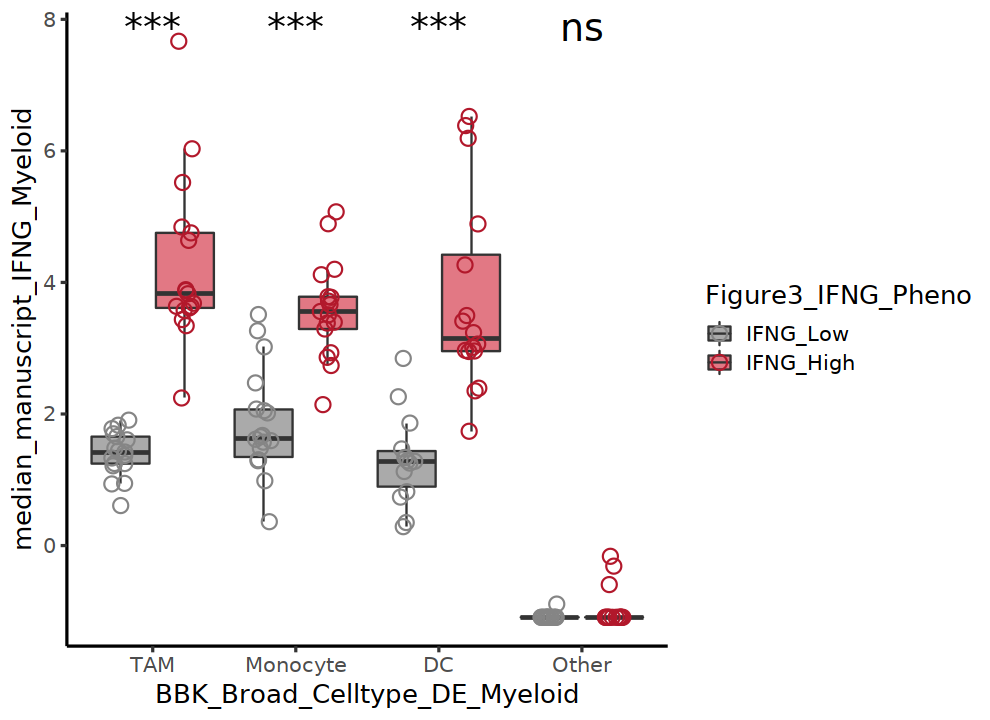

In [40]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFNG = ggplot(plot_df_IFNG_Myeloid, aes(x=BBK_Broad_Celltype_DE_Myeloid, y=median_manuscript_IFNG_Myeloid, fill=Figure3_IFNG_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFNG_Pheno,group = Figure3_IFNG_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFNG

ggsave("../Figures/Figure3/Figure3C_Myeloid_IFNG_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

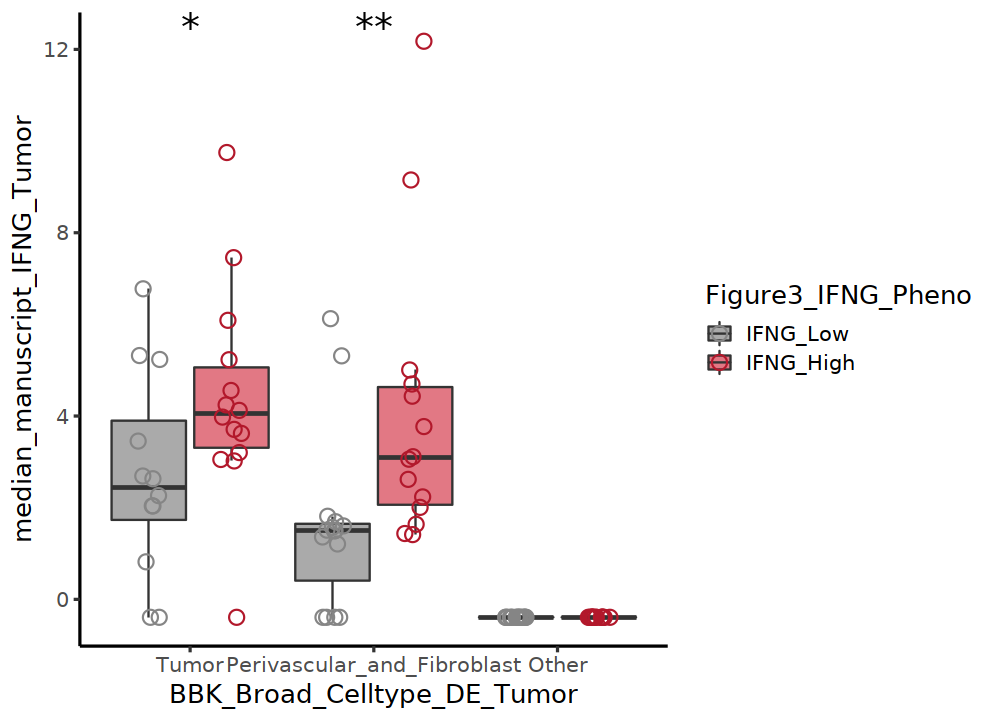

In [41]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFNG = ggplot(plot_df_IFNG_Tumor, aes(x=BBK_Broad_Celltype_DE_Tumor, y=median_manuscript_IFNG_Tumor, fill=Figure3_IFNG_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFNG_Pheno,group = Figure3_IFNG_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFNG

ggsave("../Figures/Figure3/Figure3C_Tumor_IFNG_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

In [42]:
a = subset(plot_df_IFNG_Tumor, BBK_Broad_Celltype_DE_Tumor == "Other" & Figure3_IFNG_Pheno == "IFNG_High")$median_manuscript_IFNG_Tumor
b = subset(plot_df_IFNG_Tumor, BBK_Broad_Celltype_DE_Tumor == "Other" & Figure3_IFNG_Pheno == "IFNG_Low")$median_manuscript_IFNG_Tumor

In [43]:
wilcox.test(a,b)

Warning message in wilcox.test.default(a, b):
"cannot compute exact p-value with ties"



	Wilcoxon rank sum test with continuity correction

data:  a and b
W = 162, p-value = NA
alternative hypothesis: true location shift is not equal to 0


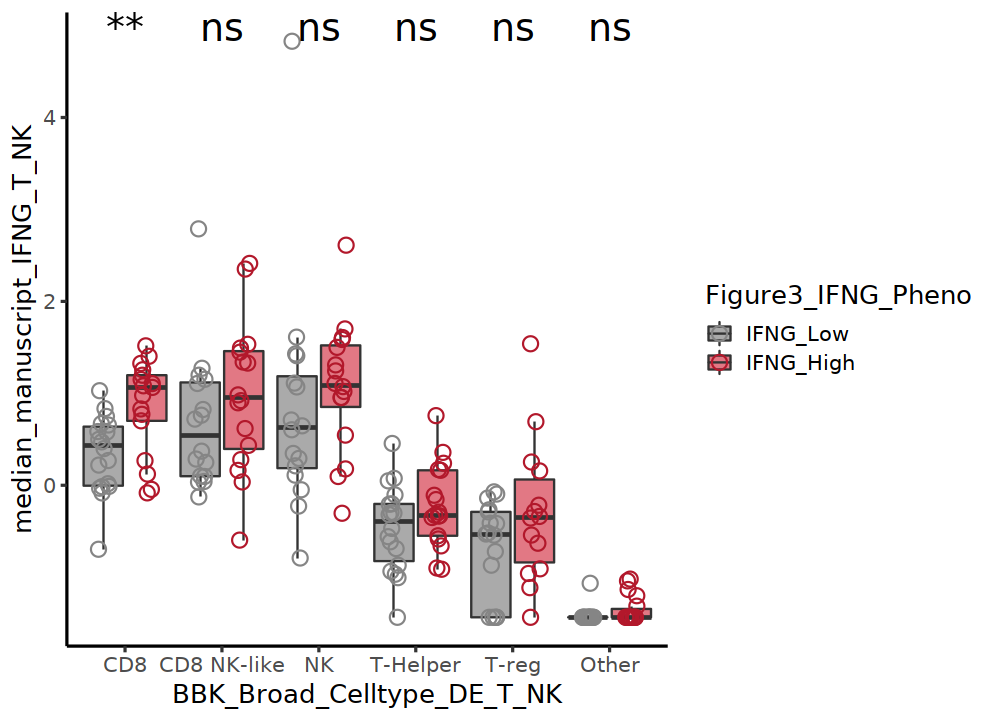

In [44]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFNG = ggplot(plot_df_IFNG_T_NK, aes(x=BBK_Broad_Celltype_DE_T_NK, y=median_manuscript_IFNG_T_NK, fill=Figure3_IFNG_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFNG_Pheno,group = Figure3_IFNG_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFNG

ggsave("../Figures/Figure3/Figure3C_T_NK_IFNG_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

### Calculate median IFN1 score per sample, grouped down by Sample and IFN1 response high and low

In [45]:
plot_df_IFN1$Figure3_IFN1_Pheno_Sample = paste(plot_df_IFN1$Figure3_IFN1_Pheno,plot_df_IFN1$Sample, sep = ".")

###

plot_df_IFN1_Myeloid = plot_df_IFN1 %>%
  group_by(Figure3_IFN1_Pheno_Sample, BBK_Broad_Celltype_DE_Myeloid, Figure3_IFN1_Pheno, Sample) %>%
  summarise(median_manuscript_IFN1_Myeloid = median(manuscript_IFN1_myeloid))

plot_df_IFN1_Tumor = plot_df_IFN1 %>%
  group_by(Figure3_IFN1_Pheno_Sample, BBK_Broad_Celltype_DE_Tumor, Figure3_IFN1_Pheno, Sample) %>%
  summarise(median_manuscript_IFN1_Tumor = median(manuscript_IFN1_tumor))

plot_df_IFN1_T_NK = plot_df_IFN1 %>%
  group_by(Figure3_IFN1_Pheno_Sample, BBK_Broad_Celltype_DE_T_NK, Figure3_IFN1_Pheno, Sample) %>%
  summarise(median_manuscript_IFN1_T_NK = median(manuscript_IFN1_t_nk))

`summarise()` has grouped output by 'Figure3_IFN1_Pheno_Sample',
'BBK_Broad_Celltype_DE_Myeloid', 'Figure3_IFN1_Pheno'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Figure3_IFN1_Pheno_Sample',
'BBK_Broad_Celltype_DE_Tumor', 'Figure3_IFN1_Pheno'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Figure3_IFN1_Pheno_Sample',
'BBK_Broad_Celltype_DE_T_NK', 'Figure3_IFN1_Pheno'. You can override using the
`.groups` argument.


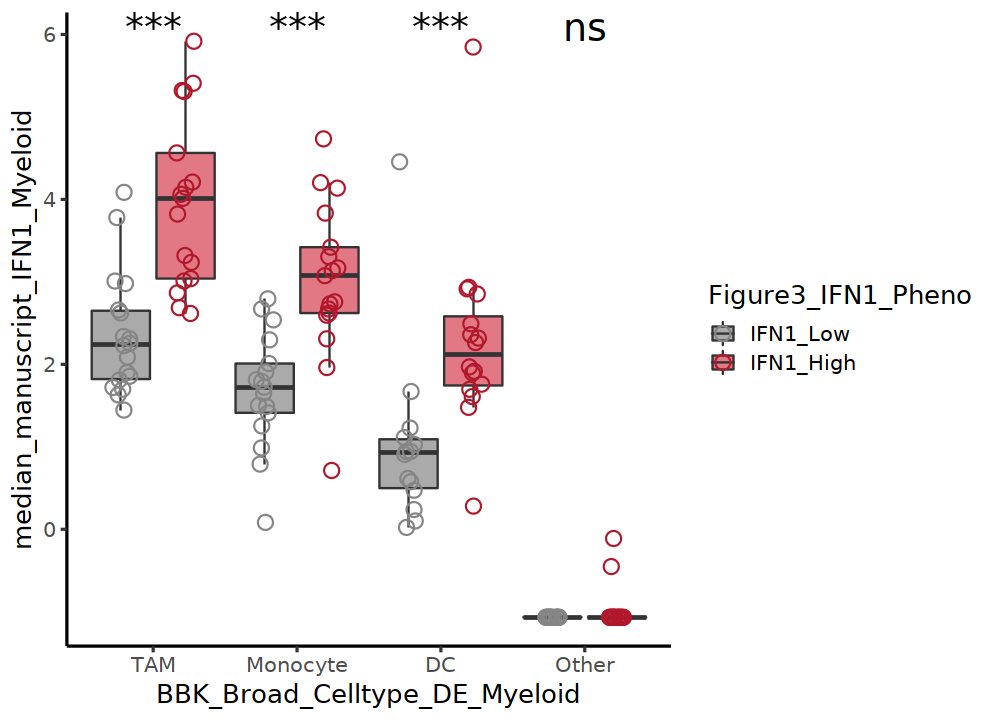

In [46]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFN1 = ggplot(plot_df_IFN1_Myeloid, aes(x=BBK_Broad_Celltype_DE_Myeloid, y=median_manuscript_IFN1_Myeloid, fill=Figure3_IFN1_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFN1_Pheno,group = Figure3_IFN1_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFN1_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFN1

ggsave("../Figures/Figure3/Figure3D_Myeloid_IFN1_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

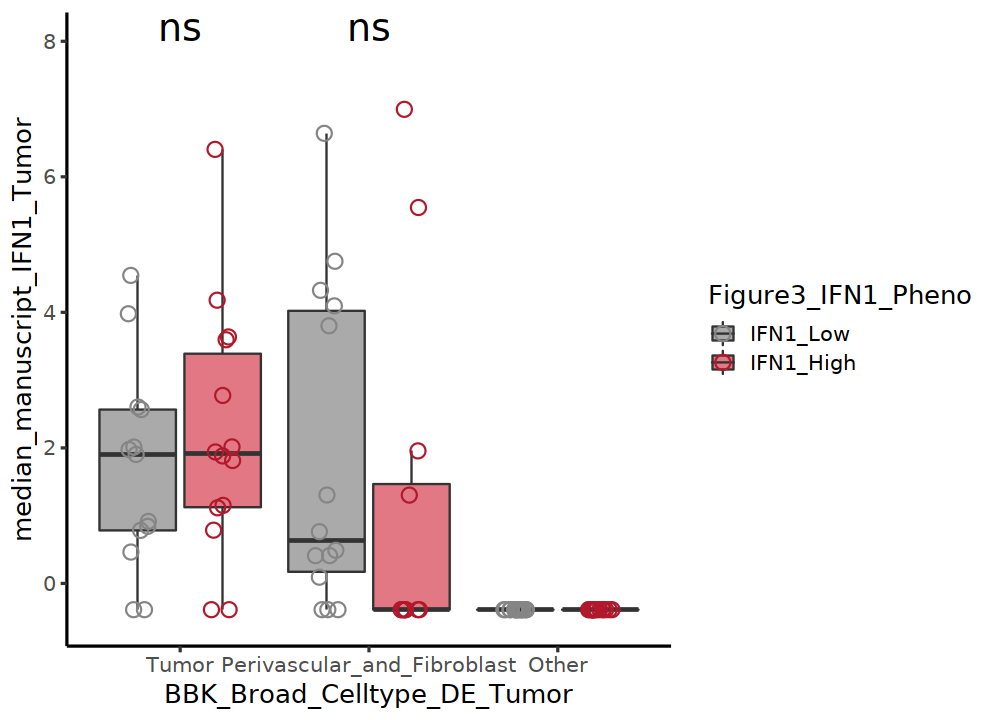

In [47]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFN1 = ggplot(plot_df_IFN1_Tumor, aes(x=BBK_Broad_Celltype_DE_Tumor, y=median_manuscript_IFN1_Tumor, fill=Figure3_IFN1_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFN1_Pheno,group = Figure3_IFN1_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFN1_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15) +
ylim(c(-0.5,8))

IFN1

ggsave("../Figures/Figure3/Figure3D_Tumor_IFN1_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

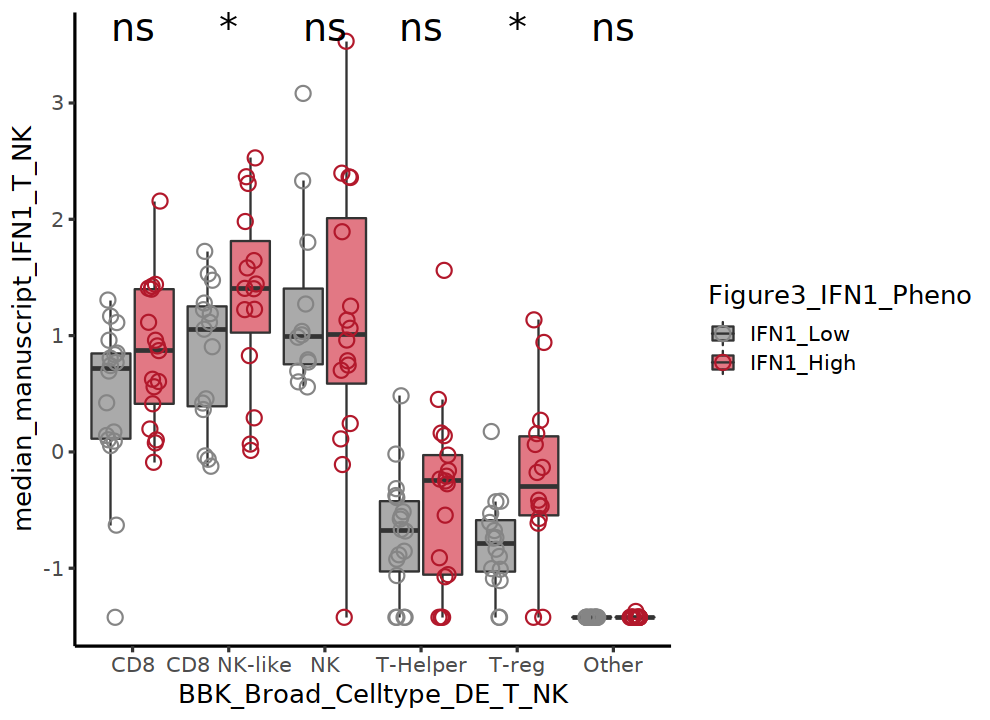

In [48]:
options(repr.plot.width=8.25, repr.plot.height=6)

IFN1 = ggplot(plot_df_IFN1_T_NK, aes(x=BBK_Broad_Celltype_DE_T_NK, y=median_manuscript_IFN1_T_NK, fill=Figure3_IFN1_Pheno)) + 
    geom_boxplot(alpha = 0.7, outlier.shape = NA, width = 0.9) + scale_fill_manual(values = c("gray52","#d53e4f")) +
scale_color_manual(values = c("gray52","#b2182b")) +
geom_jitter(aes(color = Figure3_IFN1_Pheno,group = Figure3_IFN1_Pheno),shape = 1, size = 3.5, stroke=0.7, alpha=1,position = position_jitterdodge(jitter.width = 0.25,dodge.width = 0.9)) +
stat_compare_means(aes(group = Figure3_IFN1_Pheno), label = "p.signif",size = 8,,symnum.args = signif_cutoffs) + theme_classic(base_size = 15)

IFN1

ggsave("../Figures/Figure3/Figure3D_T_NK_IFN1_Median_Boxplots_Treated.pdf", width = 8.25, height = 6)

### Score IMM151 and JAV101 bulk RNA-Seq for ISG signatures and add CIBERSORTx fractions <a name="6"></a>

In [49]:
ISG_sigs = readRDS("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/IFN_RCC_Manuscript_2024/Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [50]:
length(ISG_sigs)

[1] 240

### IMM151

In [51]:
imm151_rna = readRDS("../Trial_Cohorts/IMM151/IMM151_RNASeq_TPM.RDS")
imm151_clin = readRDS("../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata.RDS")

dim(imm151_rna)
dim(imm151_clin)

[1] 25297   823

[1] 823  92

In [52]:
options(future.globals.maxSize= 50000*1024^2)

imm151_gs = hack_sig(
  imm151_rna,
  signatures = ISG_sigs,
  method = "zscore")

In [53]:
imm151_gs_final = data.frame(imm151_gs[,2:ncol(imm151_gs)])
row.names(imm151_gs_final) = imm151_gs$sample_id

In [54]:
corner(imm151_gs_final)

setequal(row.names(imm151_gs_final),row.names(imm151_clin))

,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid,manuscript_IFNG_t_nk
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EA-37ce247b1d,-5.0547058,-3.5229063,-0.5651403,-5.9945075,-3.6849959
EA-c98e425b64,0.2675114,1.9489467,0.7658367,2.4105922,2.2322537
EA-bb52459cfb,3.6933034,1.4646782,1.9194814,3.0021903,2.0395606
EA-7e3f099861,0.9905708,1.7376840,0.6346561,2.5378846,1.5752130
EA-080ae948aa,0.7664715,-0.7538771,0.2212405,0.3692715,-0.3709755


[1] TRUE

In [55]:
clin_imm151_full = cbind(imm151_clin, imm151_gs_final)
clin_imm151_full = cbind(clin_imm151_full, data.frame(t(imm151_rna),check.names = F))

cib = read.table("../Trial_Cohorts/IMM151/IMM151_CIBERSORTx_Res_2024.txt", header = T, row.names = 1, check.names = F, sep = '\t')
colnames(cib) = paste(colnames(cib),"_CS", sep = "")
library(stringr)
colnames(cib) = str_replace_all(colnames(cib)," ","_")
colnames(cib) = str_replace_all(colnames(cib),"-","_")
colnames(cib)
corner(cib)
dim(cib)
cib

setequal(row.names(clin_imm151_full), row.names(cib))

clin_imm151_full = cbind(clin_imm151_full, cib)


cyt = clin_imm151_full[,c("GZMA","PRF1")]
corner(cyt)

calc_cyt = function(vec){
    cyt = exp(mean(log(as.numeric(vec))))
    return(cyt)
}

cyt$CYT = apply(cyt, 1, calc_cyt)
corner(cyt)

clin_imm151_full$CYT = cyt$CYT

clin_imm151_full$SEX = factor(clin_imm151_full$SEX)
clin_imm151_full$MSKCC_RISK_SCORE = factor(clin_imm151_full$MSKCC_RISK_SCORE, levels = c("High","Intermediate","Low"))
clin_imm151_full$LIVER_METASTASES = factor(clin_imm151_full$LIVER_METASTASES)
clin_imm151_full$SARCOMATOID = factor(clin_imm151_full$SARCOMATOID)

class(clin_imm151_full$AGE)
class(clin_imm151_full$SEX)
class(clin_imm151_full$MSKCC_RISK_SCORE)
class(clin_imm151_full$LIVER_METASTASES)
class(clin_imm151_full$SARCOMATOID)


[1] "Tumor_CS"             "Plasma_cell_CS"       "CD8_NK_like_CS"      
 [4] "DC_CS"                "Endothelial_CS"       "TAM_CS"              
 [7] "T_reg_CS"             "NK_CS"                "Monocyte_CS"         
[10] "B_cell_CS"            "T_Helper_CS"          "CD8_CS"              
[13] "Perivascular_cell_CS" "Fibroblast_CS"        "P_value_CS"          
[16] "Correlation_CS"       "RMSE_CS"

,Tumor_CS,Plasma_cell_CS,CD8_NK_like_CS,DC_CS,Endothelial_CS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EA-37ce247b1d,0.3741540,0.002787644,0.108806410,0.0000000,0.06391776
EA-c98e425b64,0.3210770,0.125897588,0.004743981,0.0000000,0.04912354
EA-bb52459cfb,0.2226262,0.004689752,0.000000000,0.0000000,0.02894587
EA-7e3f099861,0.3114670,0.013640173,0.000000000,0.1018227,0.11147735
EA-080ae948aa,0.1884054,0.011215563,0.000000000,0.0000000,0.16511876


[1] 823  17

,Tumor_CS,Plasma_cell_CS,CD8_NK_like_CS,DC_CS,Endothelial_CS,TAM_CS,T_reg_CS,NK_CS,Monocyte_CS,B_cell_CS,T_Helper_CS,CD8_CS,Perivascular_cell_CS,Fibroblast_CS,P_value_CS,Correlation_CS,RMSE_CS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EA-37ce247b1d,0.37415399,0.002787644,0.108806410,0.00000000,0.06391776,0.16125338,0.00000000,0.009066695,0.03403259,0.036961427,0.10894137,0.00000000,0.098107215,0.0019715260,0,0.5486659,0.8364567
EA-c98e425b64,0.32107701,0.125897588,0.004743981,0.00000000,0.04912354,0.05350001,0.02503451,0.100336642,0.05308703,0.062891872,0.10615052,0.02608867,0.057916311,0.0141523345,0,0.5218165,0.8562810
EA-bb52459cfb,0.22262616,0.004689752,0.000000000,0.00000000,0.02894587,0.21575419,0.02736717,0.150748573,0.07150831,0.057120685,0.08669843,0.10708349,0.018283916,0.0091734394,0,0.4849985,0.8749007
EA-7e3f099861,0.31146699,0.013640173,0.000000000,0.10182266,0.11147735,0.05749842,0.04999807,0.113308051,0.01895641,0.049680966,0.05351341,0.09602787,0.022485914,0.0001237091,0,0.4454368,0.8957557
EA-080ae948aa,0.18840539,0.011215563,0.000000000,0.00000000,0.16511876,0.11126671,0.00000000,0.103228404,0.07144819,0.036652794,0.14041143,0.01830226,0.132987004,0.0209635007,0,0.4574299,0.8900489
EA-95851271dc,0.33252487,0.003504400,0.023752578,0.09683716,0.11459644,0.07386037,0.02639238,0.052305915,0.01350065,0.041513471,0.09847513,0.05420777,0.062657702,0.0058711648,0,0.6344375,0.7944320
EA-fd3db26e4b,0.15947267,0.035437873,0.057200539,0.00000000,0.06904073,0.10940056,0.08220129,0.076511185,0.10346977,0.038379027,0.08400241,0.13214911,0.047494122,0.0052407146,0,0.1566895,1.0191403
EA-8bcd048f13,0.35752898,0.041763465,0.000000000,0.00000000,0.11356514,0.04765432,0.06507240,0.056688802,0.07401777,0.000000000,0.12396569,0.00000000,0.081699177,0.0380442568,0,0.3207423,0.9619228
EA-50a17b762a,0.39309840,0.035418376,0.000000000,0.00000000,0.04540647,0.10915707,0.05842284,0.075335258,0.06059293,0.000000000,0.15130532,0.03864539,0.013727596,0.0188903509,0,0.3721712,0.9342228


[1] TRUE

,GZMA,PRF1
,<dbl>,<dbl>
EA-37ce247b1d,2.221848,2.986173
EA-c98e425b64,5.203718,4.667844
EA-bb52459cfb,6.390406,6.034415
EA-7e3f099861,6.183439,5.110688
EA-080ae948aa,4.742241,3.910845


,GZMA,PRF1,CYT
,<dbl>,<dbl>,<dbl>
EA-37ce247b1d,2.221848,2.986173,2.575815
EA-c98e425b64,5.203718,4.667844,4.928503
EA-bb52459cfb,6.390406,6.034415,6.209860
EA-7e3f099861,6.183439,5.110688,5.621533
EA-080ae948aa,4.742241,3.910845,4.306526


[1] "integer"

[1] "factor"

[1] "factor"

[1] "factor"

[1] "factor"

In [56]:
saveRDS(clin_imm151_full, file = "../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

### JAV101

In [57]:
jav101_rna = readRDS("../Trial_Cohorts/JAV101/JAV101_RNASeq_TPM_log2.RDS")
jav101_clin = readRDS("../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata.RDS")

dim(jav101_rna)
dim(jav101_clin)

[1] 40032   728

[1] 728  69

In [58]:
options(future.globals.maxSize= 50000*1024^2)

jav101_gs = hack_sig(
  jav101_rna,
  signatures = ISG_sigs,
  method = "zscore")

In [59]:
jav101_gs_final = data.frame(jav101_gs[,2:ncol(jav101_gs)])
row.names(jav101_gs_final) = jav101_gs$sample_id

In [60]:
corner(jav101_gs_final)

setequal(row.names(jav101_gs_final),row.names(jav101_clin))

,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid,manuscript_IFNG_t_nk
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10011001_6203185783,-1.7899386,-1.0827914,-0.17562036,-1.6648195,-0.48011561
10011004_6204067375,-0.6490106,-3.5230931,0.52433393,-2.1192466,-3.54282924
10011006_6204067377,-0.1433420,-0.9528208,0.29489663,0.5226403,-0.27285987
10011007_6204067220,1.4421168,0.3263469,-0.04649198,1.9110461,0.26343838
10011008_6204067223,1.4223967,0.5665004,1.37561854,1.1366075,0.09528641


[1] TRUE

In [61]:
clin_jav101_full = cbind(jav101_clin, jav101_gs_final)
clin_jav101_full = cbind(clin_jav101_full, data.frame(t(jav101_rna)))

cib = read.table("../Trial_Cohorts/JAV101/JAV101_CIBERSORTx_Res_2024.txt", header = T, row.names = 1, check.names = F, sep = '\t')
colnames(cib) = paste(colnames(cib),"_CS", sep = "")
library(stringr)
colnames(cib) = str_replace_all(colnames(cib)," ","_")
colnames(cib) = str_replace_all(colnames(cib),"-","_")
colnames(cib)
corner(cib)
dim(cib)

setequal(row.names(clin_jav101_full), row.names(cib))

clin_jav101_full = cbind(clin_jav101_full, cib)

clin_jav101_full$MSKCC = factor(clin_jav101_full$MSKCC, levels = c("POOR","INTERMEDIATE","FAVORABLE"))

cyt = clin_jav101_full[,c("GZMA","PRF1")]
corner(cyt)

calc_cyt = function(vec){
    cyt = exp(mean(log(as.numeric(vec))))
    return(cyt)
}

cyt$CYT = apply(cyt, 1, calc_cyt)
corner(cyt)

clin_jav101_full$CYT = cyt$CYT

[1] "Tumor_CS"             "Plasma_cell_CS"       "CD8_NK_like_CS"      
 [4] "DC_CS"                "Endothelial_CS"       "TAM_CS"              
 [7] "T_reg_CS"             "NK_CS"                "Monocyte_CS"         
[10] "B_cell_CS"            "T_Helper_CS"          "CD8_CS"              
[13] "Perivascular_cell_CS" "Fibroblast_CS"        "P_value_CS"          
[16] "Correlation_CS"       "RMSE_CS"

,Tumor_CS,Plasma_cell_CS,CD8_NK_like_CS,DC_CS,Endothelial_CS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10011001_6203185783,0.4298872,0.02941799,0.00000000,0.01711993,0.08387205
10011004_6204067375,0.3695604,0.01732244,0.00000000,0.00000000,0.07735827
10011006_6204067377,0.2219636,0.03354051,0.00646338,0.00000000,0.15136374
10011007_6204067220,0.2126105,0.20342298,0.01963458,0.00000000,0.07499591
10011008_6204067223,0.3465823,0.03603397,0.11652607,0.00000000,0.06215872


[1] 728  17

[1] TRUE

,GZMA,PRF1
,<dbl>,<dbl>
10011001_6203185783,3.424922,2.910733
10011004_6204067375,1.565597,1.735522
10011006_6204067377,3.407353,3.799087
10011007_6204067220,3.538538,4.031219
10011008_6204067223,4.139142,4.016140


,GZMA,PRF1,CYT
,<dbl>,<dbl>,<dbl>
10011001_6203185783,3.424922,2.910733,3.157377
10011004_6204067375,1.565597,1.735522,1.648372
10011006_6204067377,3.407353,3.799087,3.597893
10011007_6204067220,3.538538,4.031219,3.776853
10011008_6204067223,4.139142,4.016140,4.077177


In [62]:
saveRDS(clin_jav101_full, file = "../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

### Figure 3E and 3F. Violin plots of ISG signature scores in IMM151 and JAV101 in samples grouped by IFNG expression and cell type fractions <a name="7"></a>

### IMM151

In [79]:
clin_imm151_full = readRDS(file = "../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

In [63]:
df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

,Var1,Freq
,<fct>,<int>
8604,IFIT3,2


In [64]:
clin_imm151_full$IFNG_2ntile = ntile(clin_imm151_full$IFNG,n = 2)
clin_imm151_full = mutate(clin_imm151_full, IFNG_2ntile_group = ifelse(IFNG_2ntile == 1, "IFNG_Low","IFNG_High"))

clin_imm151_full$TAM_CS_2ntile = ntile(clin_imm151_full$TAM_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, TAM_CS_2ntile_group = ifelse(TAM_CS_2ntile == 1, "TAM_Low","TAM_High"))

clin_imm151_full$Tumor_CS_2ntile = ntile(clin_imm151_full$Tumor_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, Tumor_CS_2ntile_group = ifelse(Tumor_CS_2ntile == 1, "Tumor_Low","Tumor_High"))

clin_imm151_full$Tumor_Fib_CS = clin_imm151_full$Tumor_CS + clin_imm151_full$Fibroblast_CS
clin_imm151_full$Tumor_Fib_CS_2ntile = ntile(clin_imm151_full$Tumor_Fib_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, Tumor_Fib_CS_2ntile_group = ifelse(Tumor_Fib_CS_2ntile == 1, "Tumor_Fib_Low","Tumor_Fib_High"))

clin_imm151_full$CD8_CS_2ntile = ntile(clin_imm151_full$CD8_CS,n = 2)
clin_imm151_full = mutate(clin_imm151_full, CD8_CS_2ntile_group = ifelse(CD8_CS_2ntile == 1, "CD8_Low","CD8_High"))

In [65]:
clin_imm151_full$IFNG_TAM_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$TAM_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_TAM_Group)

clin_imm151_full$IFNG_Tumor_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$Tumor_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_Tumor_Group)

clin_imm151_full$IFNG_Tumor_Fib_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$Tumor_Fib_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_Tumor_Fib_Group)

clin_imm151_full$IFNG_CD8_Group = paste(clin_imm151_full$IFNG_2ntile_group, clin_imm151_full$CD8_CS_2ntile_group, sep = ".")
table(clin_imm151_full$IFNG_CD8_Group)


IFNG_High.TAM_High  IFNG_High.TAM_Low  IFNG_Low.TAM_High   IFNG_Low.TAM_Low 
               226                185                185                227 


IFNG_High.Tumor_High  IFNG_High.Tumor_Low  IFNG_Low.Tumor_High 
                 152                  259                  259 
  IFNG_Low.Tumor_Low 
                 153 


IFNG_High.Tumor_Fib_High  IFNG_High.Tumor_Fib_Low  IFNG_Low.Tumor_Fib_High 
                     148                      263                      263 
  IFNG_Low.Tumor_Fib_Low 
                     149 


IFNG_High.CD8_High  IFNG_High.CD8_Low  IFNG_Low.CD8_High   IFNG_Low.CD8_Low 
               327                 84                 84                328 

In [66]:
clin_imm151_full$IFNG_TAM_Group = factor(clin_imm151_full$IFNG_TAM_Group, levels = c("IFNG_Low.TAM_Low","IFNG_Low.TAM_High","IFNG_High.TAM_Low","IFNG_High.TAM_High"))

clin_imm151_full$IFNG_Tumor_Group = factor(clin_imm151_full$IFNG_Tumor_Group, levels = c("IFNG_Low.Tumor_Low","IFNG_Low.Tumor_High","IFNG_High.Tumor_Low","IFNG_High.Tumor_High"))

clin_imm151_full$IFNG_Tumor_Fib_Group = factor(clin_imm151_full$IFNG_Tumor_Fib_Group, levels = c("IFNG_Low.Tumor_Fib_Low","IFNG_Low.Tumor_Fib_High","IFNG_High.Tumor_Fib_Low","IFNG_High.Tumor_Fib_High"))

clin_imm151_full$IFNG_CD8_Group = factor(clin_imm151_full$IFNG_CD8_Group, levels = c("IFNG_Low.CD8_Low","IFNG_Low.CD8_High","IFNG_High.CD8_Low","IFNG_High.CD8_High"))

### IFNG_myeloid score by IFNG and TAM fraction groups

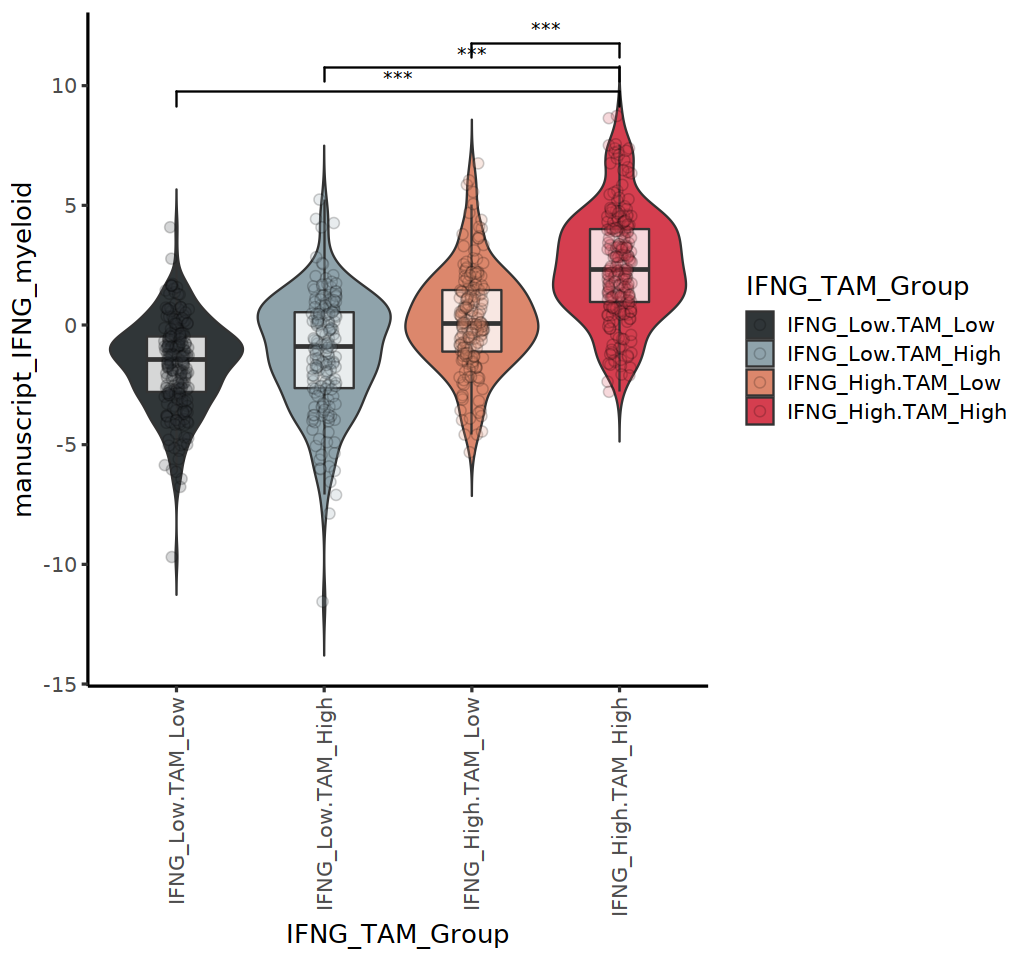

In [67]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_imm151_full, aes(x=IFNG_TAM_Group, y=manuscript_IFNG_myeloid, fill=IFNG_TAM_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_TAM_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

ggsave("../Figures/Figure3/Figure3D_TAM_manuscript_IFNG_myeloid_imm151_Violins.pdf", width = 8.5, height = 8)

### IFNG_tumor score by IFNG and Tumor + Fibroblast fraction groups

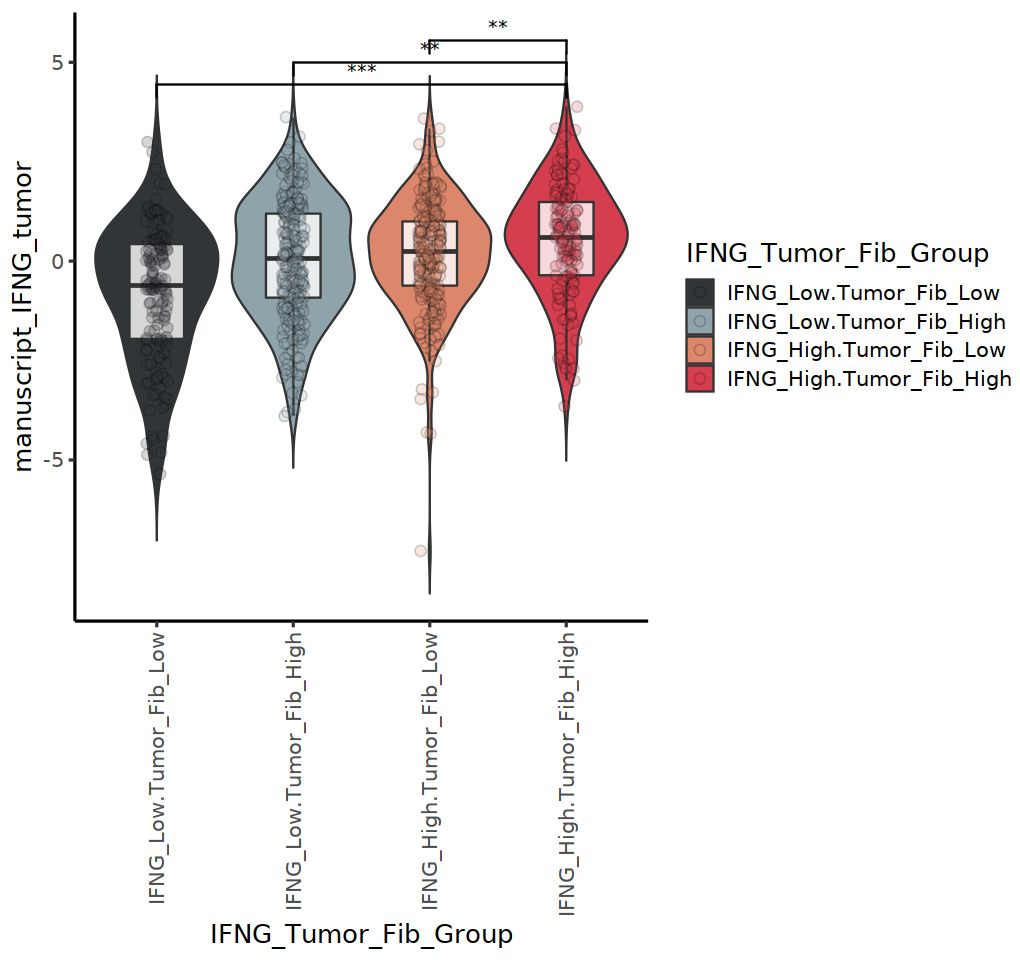

In [68]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_imm151_full, aes(x=IFNG_Tumor_Fib_Group, y=manuscript_IFNG_tumor, fill=IFNG_Tumor_Fib_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_Tumor_Fib_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

#Palette red: #ED3F39FF

ggsave("../Figures/Figure3/Figure3D_Tumor_Fib_manuscript_IFNG_tumor_imm151_Violins.pdf", width = 8.5, height = 8)

### IFNG_t_nk score by IFNG and CD8 fraction groups

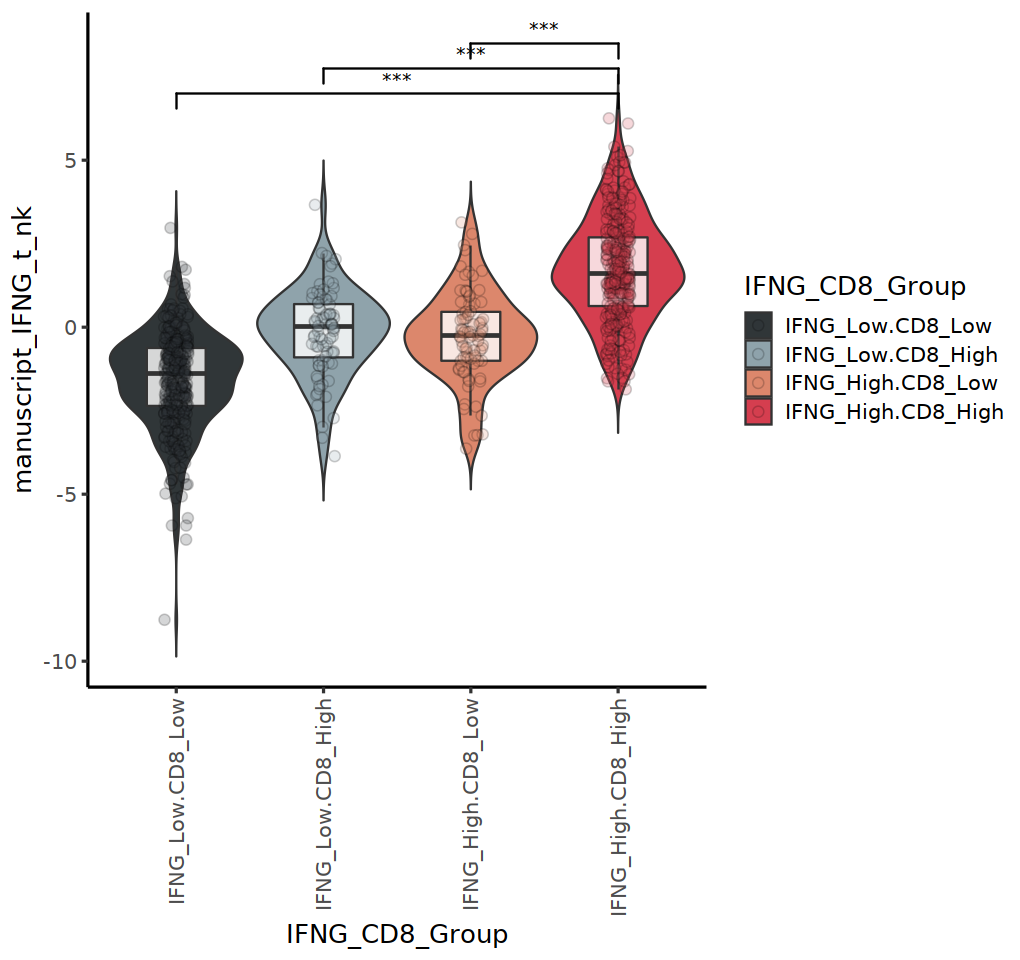

In [69]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_imm151_full, aes(x=IFNG_CD8_Group, y=manuscript_IFNG_t_nk, fill=IFNG_CD8_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_CD8_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

#Palette red: #ED3F39FF

ggsave("../Figures/Figure3/Figure3D_CD8_manuscript_IFNG_t_nk_imm151_Violins.pdf", width = 8.5, height = 8)

### JAV101

In [87]:
clin_jav101_full = readRDS(file = "../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

In [88]:
df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

,Var1,Freq
,<fct>,<int>
14682,CD8A,2
17979,Eosinophils,2
21236,IFIT3,2
27495,Neutrophils,2


In [89]:
clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

In [90]:
clin_jav101_full$IFNG_2ntile = ntile(clin_jav101_full$IFNG,n = 2)
clin_jav101_full = mutate(clin_jav101_full, IFNG_2ntile_group = ifelse(IFNG_2ntile == 1, "IFNG_Low","IFNG_High"))

clin_jav101_full$TAM_CS_2ntile = ntile(clin_jav101_full$TAM_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, TAM_CS_2ntile_group = ifelse(TAM_CS_2ntile == 1, "TAM_Low","TAM_High"))

clin_jav101_full$Tumor_CS_2ntile = ntile(clin_jav101_full$Tumor_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, Tumor_CS_2ntile_group = ifelse(Tumor_CS_2ntile == 1, "Tumor_Low","Tumor_High"))

clin_jav101_full$Tumor_Fib_CS = clin_jav101_full$Tumor_CS + clin_jav101_full$Fibroblast_CS
clin_jav101_full$Tumor_Fib_CS_2ntile = ntile(clin_jav101_full$Tumor_Fib_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, Tumor_Fib_CS_2ntile_group = ifelse(Tumor_Fib_CS_2ntile == 1, "Tumor_Fib_Low","Tumor_Fib_High"))

clin_jav101_full$CD8_CS_2ntile = ntile(clin_jav101_full$CD8_CS,n = 2)
clin_jav101_full = mutate(clin_jav101_full, CD8_CS_2ntile_group = ifelse(CD8_CS_2ntile == 1, "CD8_Low","CD8_High"))

In [91]:
clin_jav101_full$IFNG_TAM_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$TAM_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_TAM_Group)

clin_jav101_full$IFNG_Tumor_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$Tumor_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_Tumor_Group)

clin_jav101_full$IFNG_Tumor_Fib_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$Tumor_Fib_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_Tumor_Fib_Group)

clin_jav101_full$IFNG_CD8_Group = paste(clin_jav101_full$IFNG_2ntile_group, clin_jav101_full$CD8_CS_2ntile_group, sep = ".")
table(clin_jav101_full$IFNG_CD8_Group)


IFNG_High.TAM_High  IFNG_High.TAM_Low  IFNG_Low.TAM_High   IFNG_Low.TAM_Low 
               219                145                145                219 


IFNG_High.Tumor_High  IFNG_High.Tumor_Low  IFNG_Low.Tumor_High 
                 134                  230                  230 
  IFNG_Low.Tumor_Low 
                 134 


IFNG_High.Tumor_Fib_High  IFNG_High.Tumor_Fib_Low  IFNG_Low.Tumor_Fib_High 
                     129                      235                      235 
  IFNG_Low.Tumor_Fib_Low 
                     129 


IFNG_High.CD8_High  IFNG_High.CD8_Low  IFNG_Low.CD8_High   IFNG_Low.CD8_Low 
               249                115                115                249 

In [92]:
clin_jav101_full$IFNG_TAM_Group = factor(clin_jav101_full$IFNG_TAM_Group, levels = c("IFNG_Low.TAM_Low","IFNG_Low.TAM_High","IFNG_High.TAM_Low","IFNG_High.TAM_High"))

clin_jav101_full$IFNG_Tumor_Group = factor(clin_jav101_full$IFNG_Tumor_Group, levels = c("IFNG_Low.Tumor_Low","IFNG_Low.Tumor_High","IFNG_High.Tumor_Low","IFNG_High.Tumor_High"))

clin_jav101_full$IFNG_Tumor_Fib_Group = factor(clin_jav101_full$IFNG_Tumor_Fib_Group, levels = c("IFNG_Low.Tumor_Fib_Low","IFNG_Low.Tumor_Fib_High","IFNG_High.Tumor_Fib_Low","IFNG_High.Tumor_Fib_High"))

clin_jav101_full$IFNG_CD8_Group = factor(clin_jav101_full$IFNG_CD8_Group, levels = c("IFNG_Low.CD8_Low","IFNG_Low.CD8_High","IFNG_High.CD8_Low","IFNG_High.CD8_High"))

### IFNG_myeloid score by IFNG and TAM fraction groups

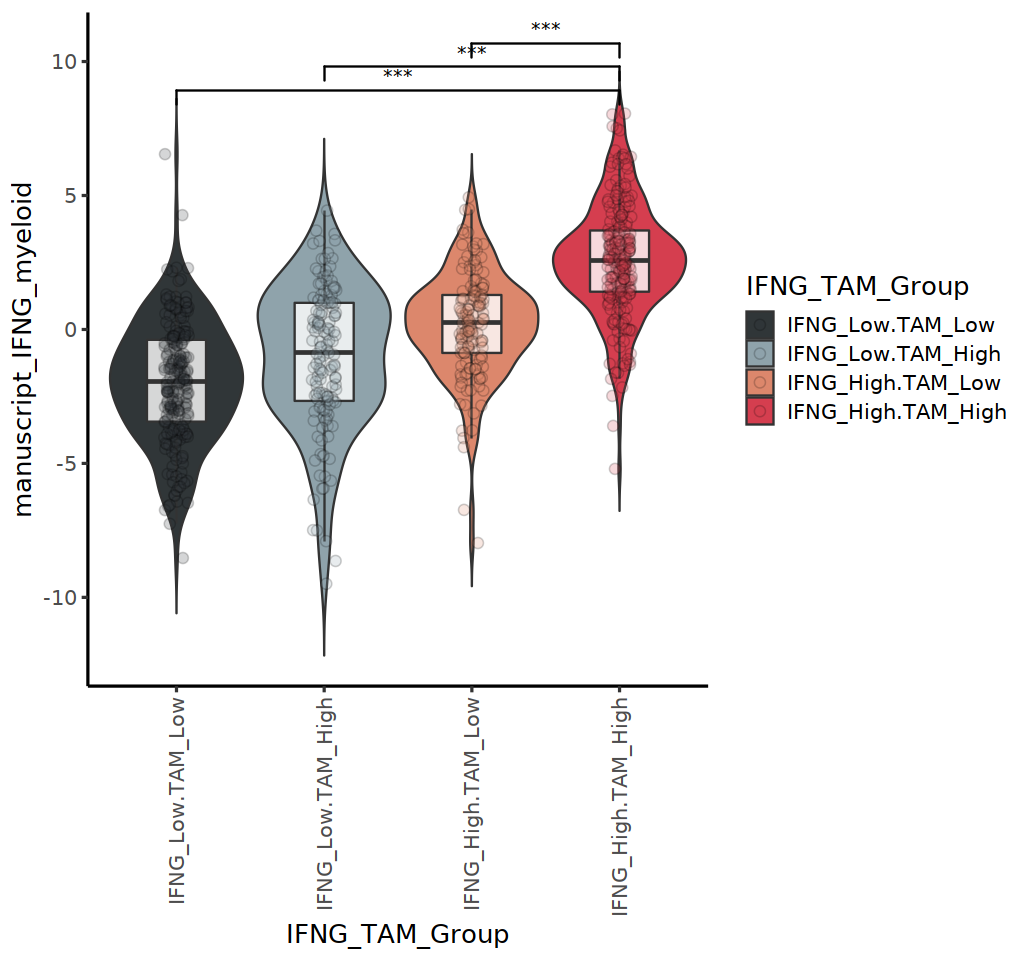

In [93]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_jav101_full, aes(x=IFNG_TAM_Group, y=manuscript_IFNG_myeloid, fill=IFNG_TAM_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_TAM_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

ggsave("../Figures/Figure3/Figure3D_TAM_manuscript_IFNG_myeloid_jav101_Violins.pdf", width = 8.5, height = 8)

### IFNG_tumor score by IFNG and Tumor + Fibroblast fraction groups

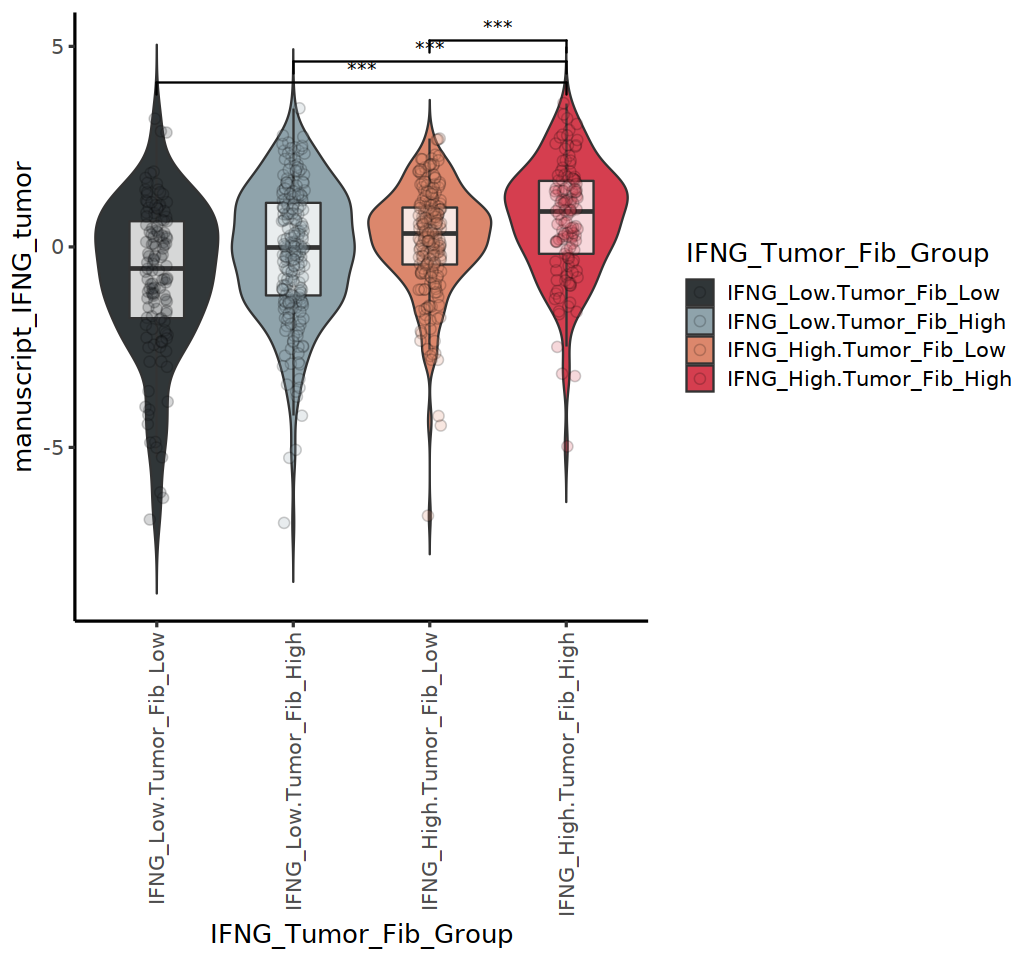

In [94]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_jav101_full, aes(x=IFNG_Tumor_Fib_Group, y=manuscript_IFNG_tumor, fill=IFNG_Tumor_Fib_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_Tumor_Fib_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

#Palette red: #ED3F39FF

ggsave("../Figures/Figure3/Figure3D_Tumor_Fib_manuscript_IFNG_tumor_jav101_Violins.pdf", width = 8.5, height = 8)

### IFNG_t_nk score by IFNG and CD8 fraction groups

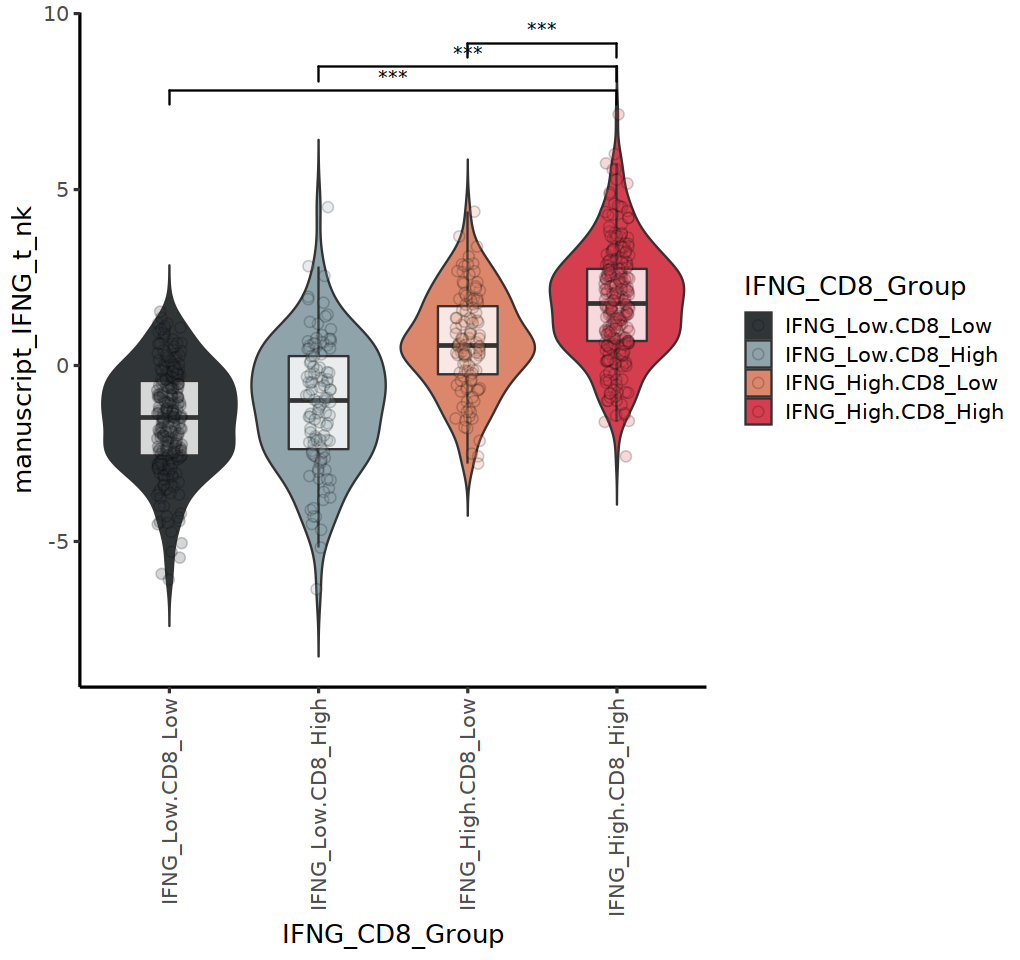

In [95]:
options(repr.plot.width=8.5, repr.plot.height=8)

ggplot(clin_jav101_full, aes(x=IFNG_CD8_Group, y=manuscript_IFNG_t_nk, fill=IFNG_CD8_Group)) + 
geom_violin(trim = F,scale = 'width') +
    geom_boxplot(fill = "white",width = 0.4,alpha = 0.8, outlier.shape = NA) +
# scale_fill_manual(values = c("gray52","#d53e4f")) +
#scale_color_manual(values = c("gray52","#d53e4f")) +
geom_jitter(aes(fill = IFNG_CD8_Group),color = "black",shape = 21, size = 2.5, alpha=0.2,position = position_jitterdodge(jitter.width = 0.5)) +
#stat_compare_means(aes(group = Figure3_IFNG_Pheno), label = "p.signif",size = 8) + 
theme_classic(base_size = 15) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
geom_signif(comparisons = list(c(1,4),c(2,4),c(3,4)),map_signif_level=TRUE,step_increase = 0.05) +
scale_color_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f")) +
scale_fill_manual(values = c("#303638FF","#8FA3ABFF","#DC876CFF","#d53e4f"))

#Palette red: #ED3F39FF

ggsave("../Figures/Figure3/Figure3D_CD8_manuscript_IFNG_t_nk_jav101_Violins.pdf", width = 8.5, height = 8)